Data shape: (9129, 363)
Any missing values?  0  (should be 0)
Identified 358 potential numeric predictors initially.
Dropped 39 columns due to suspected multicollinearity/tautology.
Columns dropped: ['e_v2x_mpi_5C_imputed_rf', 'e_v2x_delibdem_3C_imputed', 'v2x_polyarchy_imputed_rf', 'e_v2x_egaldem_3C_imputed_rf', 'e_v2xdl_delib_4C_imputed', 'e_v2xdl_delib_5C_imputed', 'v2x_libdem_imputed_rf', 'e_v2x_liberal_5C_imputed_rf', 'e_v2xel_frefair_3C_imputed', 'e_v2x_libdem_4C_imputed_rf', 'e_v2x_polyarchy_5C_imputed_rf', 'e_v2x_libdem_3C_imputed_rf', 'v2peasjgen_imputed_rf', 'e_v2x_corr_3C', 'v2x_delibdem_imputed', 'v2xdl_delib_imputed', 'e_v2xel_frefair_4C_imputed', 'v2x_partipdem_imputed_rf', 'e_v2x_libdem_5C_imputed_rf', 'e_v2x_delibdem_4C_imputed', 'v2x_liberal_imputed_rf', 'v2x_regime_amb_imputed_rf', 'e_v2x_corr_5C', 'v2x_regime_imputed_rf', 'v2x_egaldem_imputed_rf', 'v2peapsgen_imputed_rf', 'v2x_mpi_imputed_rf', 'e_v2x_corr_4C', 'e_v2xel_frefair_5C_imputed', 'v2x_EDcomp_thick_imputed_r

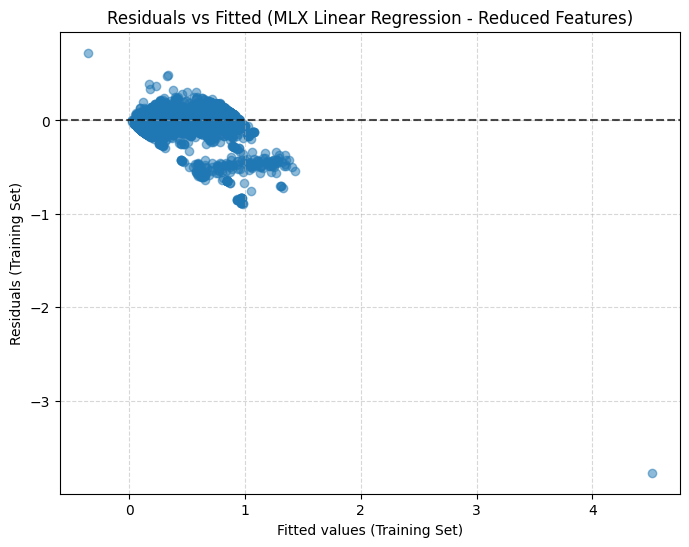

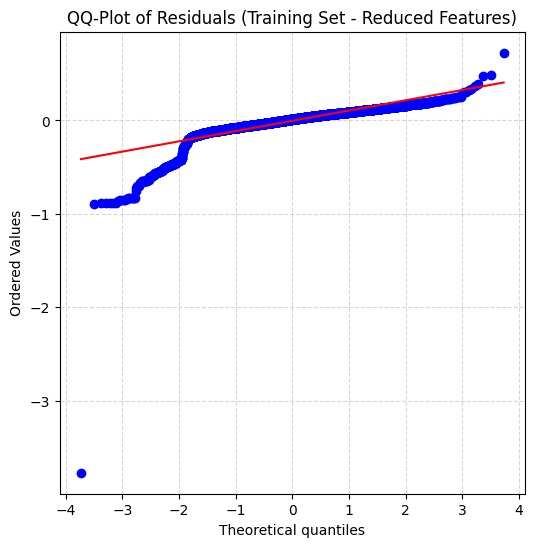

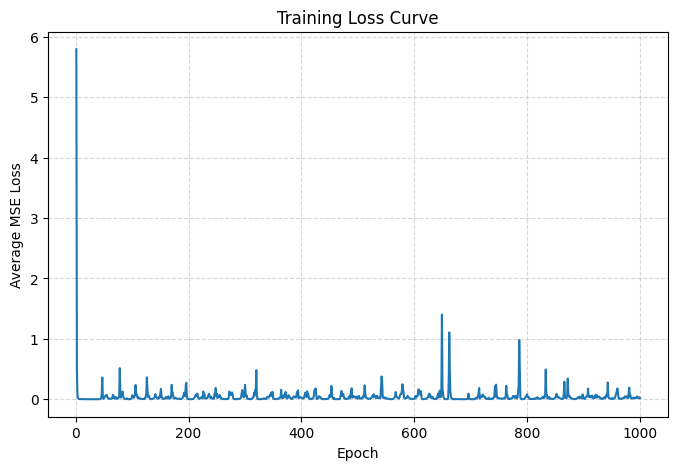


=== MLX Model Coefficients (Reduced Features) ===
                   feature  coefficient
0            v2x_polyarchy     0.026810
1               v2x_libdem     0.006232
2            v2x_partipdem     0.011105
3             v2x_delibdem     0.024615
4              v2x_egaldem    -0.004440
..                     ...          ...
315    e_ti_cpi_imputed_rf     0.003859
316  e_vanhanen_imputed_rf     0.004621
317  e_peaveduc_imputed_rf    -0.002195
318              log_gdppc     0.004367
319              intercept     0.490745

[320 rows x 2 columns]

Note: The MLX approach provides coefficients optimized via gradient descent.
It does not automatically provide standard errors, p-values, or confidence intervals like statsmodels.


In [3]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time  # To time training

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Still use sklearn for train/test split as MLX doesn't have it
from sklearn.model_selection import train_test_split
# Optionally use scipy for QQ plot if needed later
from scipy import stats


# 1. ── Load your imputed V‑Dem subset ────────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print("Data shape:", df.shape)
    print("Any missing values? ", df.isna().sum().sum(), " (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Please ensure the file exists.")
    # Create dummy data for demonstration if file not found
    print("Creating dummy data for demonstration.")
    n_samples = 1000
    n_features = 50 # Reduced features for dummy data example clarity
    feature_names = [f'feature_{i}' for i in range(n_features)]
    # Add some dummy columns that mimic problematic ones
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed']
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 2 + df['feature_1'] * -1.5 + np.random.randn(n_samples) * 0.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    # Make dummy problematic columns related to target/others
    df['e_v2x_corr_4C'] = pd.cut(df['v2x_corr'], bins=4, labels=False) + np.random.rand(n_samples)*0.1
    df['v2x_polyarchy_imputed_rf'] = df['feature_3'] + np.random.rand(n_samples)*0.1
    df['v2x_delibdem_imputed'] = df['feature_4'] + np.random.rand(n_samples)*0.1
    # Fill object columns
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define target & predictors ──────────────────────────────────────────
target = "v2x_corr"
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in DataFrame.")

# Define base columns to drop (non-predictors)
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
# Ensure only existing columns are dropped
base_drop_cols = [col for col in base_drop_cols if col in df.columns]

# Grab all potentially numeric columns initially
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Initial list of predictors (all numeric minus base drops)
predictors = [c for c in numeric_cols if c not in base_drop_cols]

# Check if predictors list is empty
if not predictors:
     raise ValueError("No predictor columns found after dropping specified columns.")
print(f"Identified {len(predictors)} potential numeric predictors initially.")


# 3. ── Drop columns suspected of multicollinearity / tautology───────────────
# Based on the analysis of the original OLS output
# Add more columns here based on your specific knowledge or further analysis
cols_to_drop_multicollinearity = [
    # Directly related to the target variable (tautological)
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C",

    # Imputed variables showing extremely high t-stats/coefficients in original OLS, suggesting issues
    "v2x_delibdem_imputed", # t-stat ~3089
    "v2xel_frefair_imputed", # t-stat ~-987 (magnitude)
    "v2xdl_delib_imputed", # t-stat ~1753
    "e_v2xdl_delib_4C_imputed", # t-stat ~-1401
    "e_v2xdl_delib_5C_imputed", # t-stat ~-500
    "e_v2x_delibdem_3C_imputed", # t-stat ~3089
    "e_v2x_delibdem_4C_imputed", # t-stat ~3089
    "e_v2x_delibdem_5C_imputed", # t-stat ~3089
    "e_v2xel_frefair_3C_imputed",# t-stat ~-1768
    "e_v2xel_frefair_4C_imputed",# t-stat ~-766
    "e_v2xel_frefair_5C_imputed", # t-stat ~476
    "v2clpolcl_imputed_rf",       # t-stat ~-1168
    "v2peasjsoecon_imputed_rf",   # t-stat ~297 (and similar pattern)
    "v2peapsgen_imputed_rf",      # t-stat ~297
    "v2peasjgen_imputed_rf",      # t-stat ~297
    "v2xpe_exlecon_imputed_rf",   # t-stat ~297

    # Add any other variables you identified as problematic from the original OLS
    # e.g., other _imputed_rf variables with very high t-stats or coeffs near +/- 1
    "v2x_polyarchy_imputed_rf",
    "v2x_libdem_imputed_rf",
    "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf",
    "v2x_mpi_imputed_rf",
    "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf",
    "v2x_regime_amb_imputed_rf",
    "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf",
    "e_v2x_egaldem_4C_imputed_rf",
    "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf",
    "e_v2x_libdem_4C_imputed_rf",
    "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf",
    "e_v2x_EDcomp_thick_5C_imputed_rf",
    "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf",
    "e_v2x_polyarchy_5C_imputed_rf",

    # Maybe drop *all* rf imputed vars as a strategy? Uncomment below if desired.
    # Or identify specific ones based on the statsmodels output's large t-values/coeffs.
]

# Find all columns ending with '_imputed_rf' (optional aggressive strategy)
# If you uncomment this, you might not need to list them individually above
# rf_imputed_cols = [col for col in predictors if col.endswith('_imputed_rf')]
# print(f"Found {len(rf_imputed_cols)} columns ending with '_imputed_rf'.")
# cols_to_drop_multicollinearity.extend(rf_imputed_cols)

# Ensure we only try to drop columns that actually exist in our current predictor list
cols_to_drop_existing = [col for col in cols_to_drop_multicollinearity if col in predictors]

# Remove duplicates from the drop list
cols_to_drop_final = list(set(cols_to_drop_existing))

# Drop the identified columns from the predictor list
predictors = [p for p in predictors if p not in cols_to_drop_final]

print(f"Dropped {len(cols_to_drop_final)} columns due to suspected multicollinearity/tautology.")
if len(cols_to_drop_final) > 0:
    print("Columns dropped:", cols_to_drop_final) # Print if any were dropped
print(f"Now using {len(predictors)} final predictors BEFORE log transform.")

# 4. ── (Optional) Log‑transform GDP per capita ───────────────────────────────
# Apply transformation directly on the DataFrame before converting to MLX
gdp_var = "e_gdppc_imputed_rf" # Make sure this variable name is correct

# Check if gdp_var is still in predictors *after* multicollinearity drop
if gdp_var in predictors and gdp_var in df.columns:
    # Ensure positivity before log transform, add small epsilon
    min_val = df[gdp_var].min()
    if min_val <= 0:
        # Use np.log for element-wise operation on the Pandas Series
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' contains non-positive values (min: {min_val}). Adding {offset:.2e} before log.")
        # Perform calculation using NumPy/Pandas directly
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else:
         # Use np.log for element-wise operation on the Pandas Series
         df["log_gdppc"] = np.log(df[gdp_var])

    # Update predictor list: remove original, add log version
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")

elif gdp_var in cols_to_drop_final: # Check if it was dropped for multicollinearity
     print(f"'{gdp_var}' was dropped due to multicollinearity/other reasons, skipping log transform.")
elif gdp_var in predictors and gdp_var not in df.columns:
    print(f"Warning: Predictor '{gdp_var}' listed but not found in DataFrame columns. Skipping log transform.")
    predictors = [p for p in predictors if p != gdp_var]
else:
    # This case means gdp_var wasn't an initial predictor or wasn't found in df
     print(f"'{gdp_var}' not found in predictors or DataFrame. Skipping log transform.")


# Final check on predictors before proceeding
predictors = [p for p in predictors if p in df.columns]
if not predictors:
     raise ValueError("No valid predictor columns remain after filtering and transformations.")
print(f"Using {len(predictors)} final predictors for the model.")


# 5. ── Prepare Data for MLX ─────────────────────────────────────────────────
# Select only the final list of predictors
X_pd = df[predictors]
y_pd = df[target]

# 6. ── Train/Test split (using sklearn before converting to MLX) ────────────
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)

# 7. ── Standardize predictors using MLX ───────────────────────────────────────
# Calculate mean and stddev from the training set (Pandas -> NumPy -> MLX)
# Ensure X_train_pd is not empty
if X_train_pd.empty:
    raise ValueError("X_train_pd is empty. Check predictor selection.")

X_train_mx_temp = mx.array(X_train_pd.values.astype(np.float32)) # Ensure float32
mean = mx.mean(X_train_mx_temp, axis=0)
std = mx.std(X_train_mx_temp, axis=0)
eps = 1e-6 # Epsilon for numerical stability

# Standardize function
def standardize(data, mean, std):
    if not isinstance(data, mx.array):
        # Convert directly from pandas/numpy ensuring float32
        data = mx.array(np.asarray(data, dtype=np.float32))
    return (data - mean) / (std + eps)

# Apply standardization
X_train_mx = standardize(X_train_pd, mean, std) # Pass DataFrame directly
X_test_mx = standardize(X_test_pd, mean, std)   # Pass DataFrame directly

# Convert target to MLX array (needs reshaping for loss function)
y_train_mx = mx.array(y_train_pd.values, dtype=mx.float32).reshape(-1, 1)
y_test_mx = mx.array(y_test_pd.values, dtype=mx.float32).reshape(-1, 1)

print("\nData standardized and converted to MLX arrays.")
print("X_train shape:", X_train_mx.shape)
print("y_train shape:", y_train_mx.shape)
print("X_test shape:", X_test_mx.shape)
print("y_test shape:", y_test_mx.shape)


# 8. ── Define Linear Regression Model and Training in MLX ───────────────────

class LinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0:
            raise ValueError(f"Number of features must be positive, got {num_features}")
        # Output dimension is 1 for standard regression
        self.linear = nn.Linear(num_features, 1)

    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

# Instantiate the model
num_features = X_train_mx.shape[1]
model = LinearRegression(num_features)
mx.eval(model.parameters()) # Evaluate parameters to initialize them

# Define loss function (Mean Squared Error)
def mse_loss(model, x, y):
    return nn.losses.mse_loss(model(x), y, reduction='mean')

# Define optimizer
learning_rate = 0.01
optimizer = optim.Adam(learning_rate=learning_rate)

# Define training step using value_and_grad
loss_and_grad_fn = nn.value_and_grad(model, mse_loss)

# Training loop
epochs = 1000
batch_size = 128 # Use mini-batches for potentially faster convergence

print(f"\n=== Training MLX Linear Regression ===")
print(f"Epochs: {epochs}, Batch Size: {batch_size}, LR: {learning_rate}")

train_losses = []
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    # Mini-batch iteration
    permutation = mx.array(np.random.permutation(X_train_mx.shape[0]))
    for i in range(0, X_train_mx.shape[0], batch_size):
        batch_indices = permutation[i : i + batch_size]
        X_batch = X_train_mx[batch_indices]
        y_batch = y_train_mx[batch_indices]

        # Calculate loss and gradients
        loss, grads = loss_and_grad_fn(model, X_batch, y_batch)

        # Update optimizer state and model parameters
        optimizer.update(model, grads)

        # Ensure computations are executed for update
        mx.eval(model.parameters(), optimizer.state)

        epoch_loss += loss.item()
        num_batches += 1

    # Handle case where num_batches might be zero if training set is smaller than batch size
    if num_batches > 0:
        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")
    elif epoch == 0: # Print loss even if only one batch run
         train_losses.append(epoch_loss) # Should not be zero if data exists
         print(f"Epoch {epoch+1}/{epochs}, Total Loss (1 batch): {epoch_loss:.4f}")


end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")
if train_losses:
    print(f"Final Training Loss: {train_losses[-1]:.4f}")


# 9. ── Evaluation Metrics in MLX ────────────────────────────────────────────

def mse_mlx(y_true, y_pred):
    return mx.mean(mx.square(y_true - y_pred))

def r2_score_mlx(y_true, y_pred):
    ss_res = mx.sum(mx.square(y_true - y_pred))
    ss_tot = mx.sum(mx.square(y_true - mx.mean(y_true)))
    # Ensure ss_tot is not zero or close to zero
    if mx.abs(ss_tot) < eps:
        return mx.array(0.0) if mx.abs(ss_res) < eps else mx.array(-np.inf) # Or handle as appropriate
    return 1 - (ss_res / ss_tot)

# 10. ── Model evaluation on test set using MLX ───────────────────────────────

def evaluate_mlx(model, X_t, y_t):
    if X_t.shape[0] == 0 or y_t.shape[0] == 0:
        print("  Evaluation skipped: Test set is empty.")
        return None

    model.eval() # Set model to evaluation mode
    preds = model(X_t)
    mx.eval(preds) # Ensure predictions are calculated

    r2 = r2_score_mlx(y_t, preds)
    mse = mse_mlx(y_t, preds)
    rmse = mx.sqrt(mse)

    # Convert metrics to Python scalars for printing
    print(f"  R²:    {r2.item():.4f}")
    print(f"  MSE:   {mse.item():.4f}")
    print(f"  RMSE:  {rmse.item():.4f}")
    model.train() # Set back to training mode
    return preds # Return predictions for diagnostics

print("\n--- MLX Linear Regression Test-set performance (Reduced Features) ---")
test_preds_mx = evaluate_mlx(model, X_test_mx, y_test_mx)


# 11. ── Diagnostics (using MLX arrays converted to NumPy for plotting) ──────

print("\n--- Generating Diagnostics (using Matplotlib) ---")

# Calculate residuals and fitted values on the TRAINING set
if X_train_mx.shape[0] > 0 and y_train_mx.shape[0] > 0:
    train_preds_mx = model(X_train_mx)
    residuals_mx = y_train_mx - train_preds_mx
    fitted_mx = train_preds_mx
    mx.eval(residuals_mx, fitted_mx) # Compute them

    # Convert to NumPy for plotting
    residuals_np = np.array(residuals_mx).flatten()
    fitted_np = np.array(fitted_mx).flatten()

    # Residuals vs Fitted
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_np, residuals_np, alpha=0.5)
    plt.axhline(0, linestyle="--", color="k", alpha=0.7)
    plt.xlabel("Fitted values (Training Set)")
    plt.ylabel("Residuals (Training Set)")
    plt.title("Residuals vs Fitted (MLX Linear Regression - Reduced Features)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # QQ‑plot of residuals (using scipy.stats on NumPy array)
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals_np, dist="norm", plot=plt)
    plt.title("QQ‑Plot of Residuals (Training Set - Reduced Features)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Skipping training set diagnostics: Training set is empty.")


# Plot Training Loss Curve (if training happened)
if train_losses:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses) # Adjust x-axis length
    plt.xlabel("Epoch")
    plt.ylabel("Average MSE Loss")
    plt.title("Training Loss Curve")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# 12. ── Coefficient Output from MLX Model ───────────────────────────────────

# Ensure weights and bias are computed
mx.eval(model.linear.weight, model.linear.bias)

# Get weights (coefficients) and bias (intercept)
weights = model.linear.weight.squeeze() # Remove extra dimension
bias = model.linear.bias

print("\n=== MLX Model Coefficients (Reduced Features) ===")
# Ensure predictors list is not empty before creating DataFrame
if predictors:
    coef_values = np.concatenate([np.array(weights), np.array(bias)])
    if len(predictors) + 1 == len(coef_values): # Check alignment
      coef_df = pd.DataFrame({
          'feature': predictors + ['intercept'],
          'coefficient': coef_values
      })
      print(coef_df)
    else:
        print("Error: Mismatch between number of predictors and coefficients.")
        print(f"Predictors: {len(predictors)}, Weights: {len(weights)}, Bias: {len(bias)}")
else:
    print("No predictors left to display coefficients for.")


print("\nNote: The MLX approach provides coefficients optimized via gradient descent.")
print("It does not automatically provide standard errors, p-values, or confidence intervals like statsmodels.")

Data shape: (9129, 363)
Any missing values?  0  (should be 0)
Identified 358 potential numeric predictors initially.
Dropped 39 columns due to suspected multicollinearity/tautology.
Columns dropped: ['e_v2x_EDcomp_thick_5C_imputed_rf', 'e_v2x_corr_3C', 'e_v2x_corr_4C', 'e_v2x_corr_5C', 'e_v2x_delibdem_3C_imputed', 'e_v2x_delibdem_4C_imputed', 'e_v2x_delibdem_5C_imputed', 'e_v2x_egaldem_3C_imputed_rf', 'e_v2x_egaldem_4C_imputed_rf', 'e_v2x_egaldem_5C_imputed_rf', 'e_v2x_libdem_3C_imputed_rf', 'e_v2x_libdem_4C_imputed_rf', 'e_v2x_libdem_5C_imputed_rf', 'e_v2x_liberal_4C_imputed_rf', 'e_v2x_liberal_5C_imputed_rf', 'e_v2x_mpi_5C_imputed_rf', 'e_v2x_polyarchy_5C_imputed_rf', 'e_v2xdl_delib_4C_imputed', 'e_v2xdl_delib_5C_imputed', 'e_v2xel_frefair_3C_imputed', 'e_v2xel_frefair_4C_imputed', 'e_v2xel_frefair_5C_imputed', 'v2clpolcl_imputed_rf', 'v2peapsgen_imputed_rf', 'v2peasjgen_imputed_rf', 'v2peasjsoecon_imputed_rf', 'v2x_EDcomp_thick_imputed_rf', 'v2x_delibdem_imputed', 'v2x_egaldem_imput

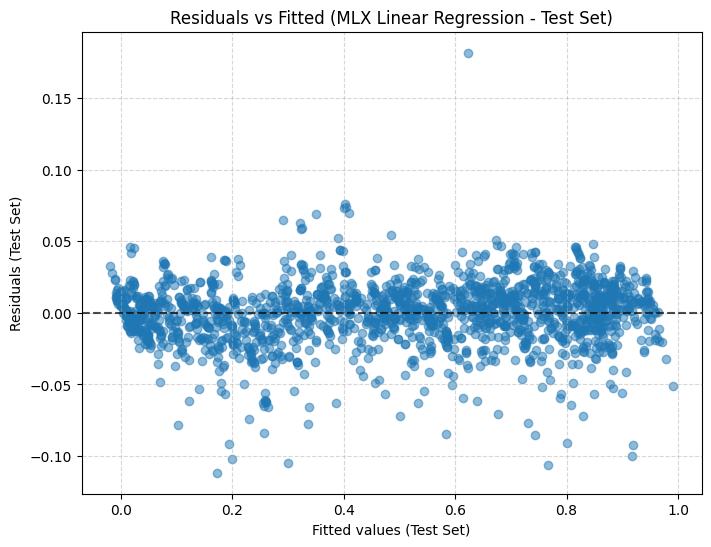

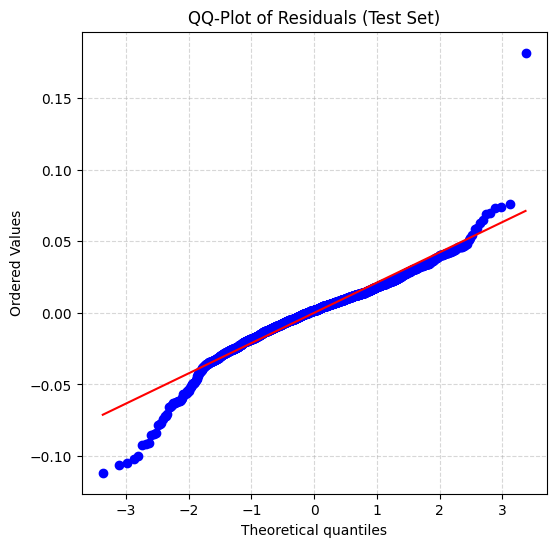

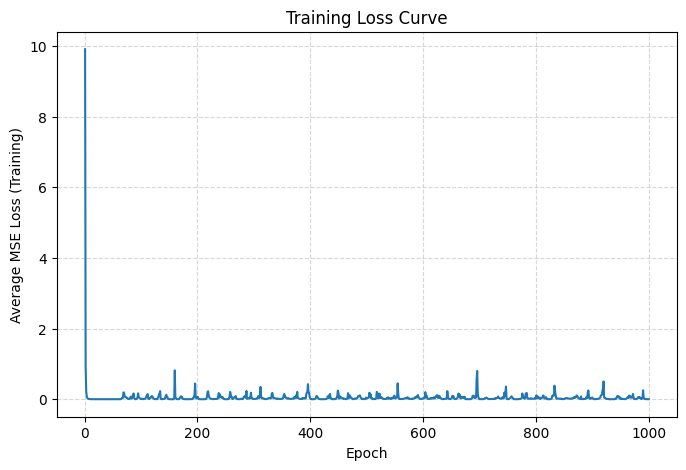


=== MLX Model Coefficients (Learned from Training Data) ===
                   feature  coefficient
0            v2x_polyarchy     0.024765
1               v2x_libdem     0.009692
2            v2x_partipdem     0.010136
3             v2x_delibdem     0.017597
4              v2x_egaldem    -0.010332
..                     ...          ...
315    e_ti_cpi_imputed_rf    -0.000370
316  e_vanhanen_imputed_rf    -0.000860
317  e_peaveduc_imputed_rf    -0.001393
318              log_gdppc     0.001398
319              intercept     0.487458

[320 rows x 2 columns]

--- Script Finished ---
Final evaluation on Test Set: R² = 0.9945, RMSE = 0.0217


In [4]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time  # To time training

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Still use sklearn for train/test split as MLX doesn't have it
from sklearn.model_selection import train_test_split
# Optionally use scipy for QQ plot if needed later
from scipy import stats


# 1. ── Load your imputed V‑Dem subset ────────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print("Data shape:", df.shape)
    print("Any missing values? ", df.isna().sum().sum(), " (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Please ensure the file exists.")
    # Create dummy data for demonstration if file not found
    print("Creating dummy data for demonstration.")
    n_samples = 1000
    n_features = 50 # Reduced features for dummy data example clarity
    feature_names = [f'feature_{i}' for i in range(n_features)]
    # Add some dummy columns that mimic problematic ones
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed']
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 2 + df['feature_1'] * -1.5 + np.random.randn(n_samples) * 0.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    # Make dummy problematic columns related to target/others
    df['e_v2x_corr_4C'] = pd.cut(df['v2x_corr'], bins=4, labels=False) + np.random.rand(n_samples)*0.1
    df['v2x_polyarchy_imputed_rf'] = df['feature_3'] + np.random.rand(n_samples)*0.1
    df['v2x_delibdem_imputed'] = df['feature_4'] + np.random.rand(n_samples)*0.1
    # Fill object columns
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define target & predictors ──────────────────────────────────────────
target = "v2x_corr"
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in DataFrame.")

# Define base columns to drop (non-predictors)
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
# Ensure only existing columns are dropped
base_drop_cols = [col for col in base_drop_cols if col in df.columns]

# Grab all potentially numeric columns initially
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Initial list of predictors (all numeric minus base drops)
predictors = [c for c in numeric_cols if c not in base_drop_cols]

# Check if predictors list is empty
if not predictors:
     raise ValueError("No predictor columns found after dropping specified columns.")
print(f"Identified {len(predictors)} potential numeric predictors initially.")


# 3. ── Drop columns suspected of multicollinearity / tautology───────────────
# Based on the analysis of the original OLS output
cols_to_drop_multicollinearity = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C",
    "v2x_delibdem_imputed", "v2xel_frefair_imputed", "v2xdl_delib_imputed",
    "e_v2xdl_delib_4C_imputed", "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed",
    "e_v2x_delibdem_4C_imputed", "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed",
    "e_v2xel_frefair_4C_imputed", "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf",
    "v2peasjsoecon_imputed_rf", "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf",
    "v2xpe_exlecon_imputed_rf", "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf",
    "v2x_partipdem_imputed_rf", "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf",
    "v2x_liberal_imputed_rf", "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf",
    "v2x_EDcomp_thick_imputed_rf", "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf",
    "e_v2x_egaldem_5C_imputed_rf", "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf",
    "e_v2x_libdem_5C_imputed_rf", "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf",
    "e_v2x_liberal_4C_imputed_rf", "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",
]
# Find all columns ending with '_imputed_rf' (optional aggressive strategy)
# rf_imputed_cols = [col for col in predictors if col.endswith('_imputed_rf')]
# cols_to_drop_multicollinearity.extend(rf_imputed_cols)
cols_to_drop_existing = [col for col in cols_to_drop_multicollinearity if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing))
predictors = [p for p in predictors if p not in cols_to_drop_final]
print(f"Dropped {len(cols_to_drop_final)} columns due to suspected multicollinearity/tautology.")
if len(cols_to_drop_final) > 0:
    # Sort dropped columns for easier reading
    print("Columns dropped:", sorted(cols_to_drop_final))
print(f"Now using {len(predictors)} final predictors BEFORE log transform.")


# 4. ── (Optional) Log‑transform GDP per capita ───────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' contains non-positive values (min: {min_val}). Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else:
         df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_final:
     print(f"'{gdp_var}' was previously dropped, skipping log transform.")
elif gdp_var in predictors and gdp_var not in df.columns:
    print(f"Warning: Predictor '{gdp_var}' listed but not found in DataFrame columns. Skipping log transform.")
    predictors = [p for p in predictors if p != gdp_var]
else:
     print(f"'{gdp_var}' not found in relevant predictors or DataFrame. Skipping log transform.")

# Final check on predictors before proceeding
predictors = [p for p in predictors if p in df.columns]
if not predictors:
     raise ValueError("No valid predictor columns remain after filtering and transformations.")
print(f"Using {len(predictors)} final predictors for the model.")


# 5. ── Prepare Data: Select final columns for X and y (in Pandas) ──────────
X_pd = df[predictors]
y_pd = df[target]


# 6. ── Train/Test Split: Divide data BEFORE training/standardization─────────
# This step divides the *entire dataset* into portions for training and unbiased evaluation.
print("\n--- Splitting Data into Training and Test Sets ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42 # 20% for testing
)
print(f"Training set size: {X_train_pd.shape[0]} observations")
print(f"Test set size: {X_test_pd.shape[0]} observations")


# 7. ── Standardize predictors using MLX ───────────────────────────────────────
# IMPORTANT: Calculate mean and std *only* from the TRAINING data (X_train_pd)
# Then apply this transformation to *both* train and test sets.
print("\n--- Standardizing Features ---")
if X_train_pd.empty:
    raise ValueError("X_train_pd is empty. Check predictor selection.")

X_train_mx_temp = mx.array(X_train_pd.values.astype(np.float32)) # Ensure float32
mean = mx.mean(X_train_mx_temp, axis=0)
std = mx.std(X_train_mx_temp, axis=0)
eps = 1e-6 # Epsilon for numerical stability
print("Calculated mean and stddev from training data.")

# Standardize function
def standardize(data, mean, std):
    if not isinstance(data, mx.array):
        data = mx.array(np.asarray(data, dtype=np.float32))
    return (data - mean) / (std + eps)

# Apply standardization using train set's mean/std
X_train_mx = standardize(X_train_pd, mean, std)
X_test_mx = standardize(X_test_pd, mean, std)
print("Applied standardization to both training and test sets.")

# Convert target to MLX array (needs reshaping for loss function)
y_train_mx = mx.array(y_train_pd.values, dtype=mx.float32).reshape(-1, 1)
y_test_mx = mx.array(y_test_pd.values, dtype=mx.float32).reshape(-1, 1)

print("\nData standardized and converted to MLX arrays.")
print("X_train shape:", X_train_mx.shape)
print("y_train shape:", y_train_mx.shape)
print("X_test shape:", X_test_mx.shape)
print("y_test shape:", y_test_mx.shape)


# 8. ── Define Linear Regression Model and Training Components in MLX ────────

class LinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0:
            raise ValueError(f"Number of features must be positive, got {num_features}")
        self.linear = nn.Linear(num_features, 1) # Input features -> 1 output

    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

# Loss function (Mean Squared Error)
def mse_loss(model, x, y):
    return nn.losses.mse_loss(model(x), y, reduction='mean')

# Optimizer
learning_rate = 0.01
optimizer = optim.Adam(learning_rate=learning_rate)

# Value and Gradient function for training updates
# Ensure model is defined before calling this
num_features = X_train_mx.shape[1]
model = LinearRegression(num_features)
mx.eval(model.parameters()) # Initialize model parameters

loss_and_grad_fn = nn.value_and_grad(model, mse_loss)


# 9. ── Train the Model using ONLY the Training Data ─────────────────────────
print(f"\n=== Training MLX Linear Regression ===")
epochs = 1000
batch_size = 128
print(f"Using {epochs} epochs, Batch Size: {batch_size}, LR: {learning_rate}")

train_losses = []
start_time = time.time()
model.train() # Set model to training mode

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    # Shuffle training data each epoch
    permutation = mx.array(np.random.permutation(X_train_mx.shape[0]))
    for i in range(0, X_train_mx.shape[0], batch_size):
        batch_indices = permutation[i : i + batch_size]
        X_batch = X_train_mx[batch_indices]
        y_batch = y_train_mx[batch_indices]

        # Calculate loss and gradients for the batch
        loss, grads = loss_and_grad_fn(model, X_batch, y_batch)

        # Update optimizer state and model parameters
        optimizer.update(model, grads)

        # Crucial: Ensure updates are executed
        mx.eval(model.parameters(), optimizer.state)

        epoch_loss += loss.item()
        num_batches += 1

    if num_batches > 0:
        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_epoch_loss:.4f}")
    elif epoch == 0:
         train_losses.append(epoch_loss)
         print(f"Epoch {epoch+1}/{epochs}, Total Loss (1 batch): {epoch_loss:.4f}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")
if train_losses:
    print(f"Final Training Loss: {train_losses[-1]:.4f}")


# 10. ── Define Evaluation Metrics in MLX ───────────────────────────────────

def mse_mlx(y_true, y_pred):
    return mx.mean(mx.square(y_true - y_pred))

def r2_score_mlx(y_true, y_pred):
    ss_res = mx.sum(mx.square(y_true - y_pred))
    ss_tot = mx.sum(mx.square(y_true - mx.mean(y_true)))
    if mx.abs(ss_tot) < eps: # Avoid division by zero if variance is tiny
        return mx.array(0.0) if mx.abs(ss_res) < eps else mx.array(-np.inf)
    return 1 - (ss_res / ss_tot)


# 11. ── Evaluate the Trained Model on the UNSEEN Test Data ─────────────────
# This provides an unbiased assessment of the model's generalization ability.

def evaluate_mlx(model, X_t, y_t, description="Test Set"):
    """Evaluates the model on the provided data."""
    print(f"\n--- Evaluating Model on {description} ---")
    if X_t.shape[0] == 0 or y_t.shape[0] == 0:
        print("  Evaluation skipped: Data set is empty.")
        return None, None, None, None # Return None for metrics

    model.eval() # Set model to evaluation mode (important for some layers, good practice)
    preds = model(X_t)
    mx.eval(preds) # Ensure predictions are calculated

    r2 = r2_score_mlx(y_t, preds)
    mse = mse_mlx(y_t, preds)
    rmse = mx.sqrt(mse)

    # Ensure metrics are calculated before converting
    mx.eval(r2, mse, rmse)

    # Convert metrics to Python scalars for printing/use
    r2_val = r2.item()
    mse_val = mse.item()
    rmse_val = rmse.item()

    print(f"  R²:    {r2_val:.4f}")
    print(f"  MSE:   {mse_val:.4f}")
    print(f"  RMSE:  {rmse_val:.4f}")
    model.train() # Set back to training mode (good practice)
    return preds, r2_val, mse_val, rmse_val # Return predictions and scalar metrics

# Perform the evaluation on the TEST SET
test_preds_mx, test_r2, test_mse, test_rmse = evaluate_mlx(
    model, X_test_mx, y_test_mx, description="Test Set (Unseen Data)"
)

# Optional: Evaluate on the Training set too, to check for overfitting
# High train R2 and much lower test R2 indicates overfitting.
# train_preds_mx_eval, train_r2, train_mse, train_rmse = evaluate_mlx(
#     model, X_train_mx, y_train_mx, description="Training Set"
# )


# 12. ── Diagnostics (using NumPy for plotting) ─────────────────────────────

print("\n--- Generating Diagnostics (using Matplotlib) ---")

# Use TEST set predictions and residuals for generalization diagnostics
if test_preds_mx is not None:
    residuals_mx_test = y_test_mx - test_preds_mx
    fitted_mx_test = test_preds_mx
    mx.eval(residuals_mx_test, fitted_mx_test) # Compute them

    # Convert to NumPy for plotting
    residuals_np_test = np.array(residuals_mx_test).flatten()
    fitted_np_test = np.array(fitted_mx_test).flatten()

    # Residuals vs Fitted (Test Set)
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_np_test, residuals_np_test, alpha=0.5)
    plt.axhline(0, linestyle="--", color="k", alpha=0.7)
    plt.xlabel("Fitted values (Test Set)")
    plt.ylabel("Residuals (Test Set)")
    plt.title("Residuals vs Fitted (MLX Linear Regression - Test Set)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # QQ‑plot of residuals (Test Set)
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals_np_test, dist="norm", plot=plt)
    plt.title("QQ‑Plot of Residuals (Test Set)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Skipping test set diagnostics plots as test evaluation failed.")

# Plot Training Loss Curve (if training happened)
if train_losses:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Average MSE Loss (Training)")
    plt.title("Training Loss Curve")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# 13. ── Coefficient Output from MLX Model ───────────────────────────────────

# Ensure weights and bias are computed after training
mx.eval(model.linear.weight, model.linear.bias)

# Get weights (coefficients) and bias (intercept)
weights = model.linear.weight.squeeze() # Remove extra dimension
bias = model.linear.bias

print("\n=== MLX Model Coefficients (Learned from Training Data) ===")
if predictors: # Ensure predictors list is valid
    # Ensure weights calculation didn't fail
    if weights is not None and bias is not None:
        coef_values = np.concatenate([np.array(weights), np.array(bias)])
        if len(predictors) + 1 == len(coef_values): # Check alignment
          coef_df = pd.DataFrame({
              'feature': predictors + ['intercept'],
              'coefficient': coef_values
          })
          # Optional: Sort by absolute coefficient magnitude
          # coef_df['abs_coef'] = coef_df['coefficient'].abs()
          # coef_df = coef_df.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)
          print(coef_df)
        else:
            print("Error: Mismatch between number of predictors and coefficients.")
            print(f"Predictors: {len(predictors)}, Weights: {len(weights)}, Bias: {len(bias)}")
    else:
        print("Error: Could not retrieve model weights or bias.")
else:
    print("No predictors available to display coefficients for.")


print("\n--- Script Finished ---")
print(f"Final evaluation on Test Set: R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Dropped 39 columns due to suspected multicollinearity/tautology.
Now using 319 predictors BEFORE log transform.
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 319 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking ---

Processing: MLX Linear
  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...
  MLX Training finished in 29.51 seconds.
  Test R²: 0.9891, Test RMSE: 0.0307

Processing: Linear Regression (SKL)
  SKL Training finished in 0.11 seconds.
  Test R²: 0.9972, Test RMSE: 0.0154

Processing: RidgeCV (SKL)
  SKL Training finished in 0.75 seconds.
  Test R²: 0.9972, Test RMSE: 0.0154

Processing: LassoCV (SKL)
  SKL

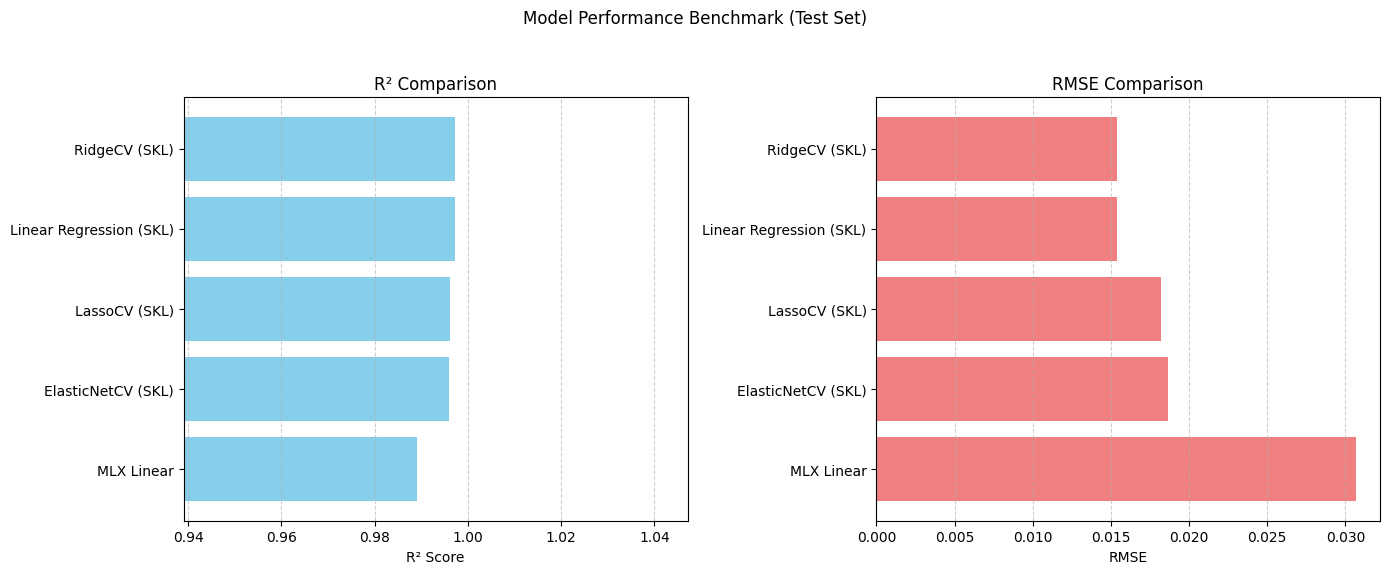


--- Script Finished ---


In [6]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import to check version

# Optional: Scipy for QQ plot if needed for specific model diagnostics later
from scipy import stats

# Ignore convergence warnings from LassoCV/ElasticNetCV for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation (same as before)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)]
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed'] # Add other dropped cols if needed for dummy
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 2 + df['feature_1'] * -1.5 + df['feature_2'] * 0.5 + np.random.randn(n_samples) * 0.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    df['e_v2x_corr_4C'] = pd.cut(df['v2x_corr'], bins=4, labels=False) + np.random.rand(n_samples)*0.1
    df['v2x_polyarchy_imputed_rf'] = df['feature_3'] + np.random.rand(n_samples)*0.1
    df['v2x_delibdem_imputed'] = df['feature_4'] + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")

cols_to_drop_multicollinearity = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",
]
cols_to_drop_existing = [col for col in cols_to_drop_multicollinearity if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing))
predictors = [p for p in predictors if p not in cols_to_drop_final]
print(f"Dropped {len(cols_to_drop_final)} columns due to suspected multicollinearity/tautology.")
print(f"Now using {len(predictors)} predictors BEFORE log transform.")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_final: print(f"'{gdp_var}' previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")

predictors = [p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
X_pd = df[predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 7. ── Define MLX Linear Regression Model & Training Function (Corrected) ───
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    """Trains the MLX Linear Regression model."""
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")

    # --- FIX 1: Define model, loss_grad_fn, and optimizer INSIDE the function ---
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters()) # Initialize before defining loss/grad

    def mse_loss(model, x, y): # Define local loss function if needed
        return nn.losses.mse_loss(model(x), y, reduction='mean')

    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    # --- End Fix 1 ---

    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.")
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark = {
    "MLX Linear": None,
    "Linear Regression (SKL)": SkLinearRegression(),
    "RidgeCV (SKL)": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV (SKL)": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001),
    "ElasticNetCV (SKL)": ElasticNetCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
}
num_features = X_train_np.shape[1]


# 9. ── Run Benchmark Loop (Corrected Evaluation) ────────────────────────────
print("\n--- Starting Model Benchmarking ---")
benchmark_results = []

for name, model in models_to_benchmark.items():
    print(f"\nProcessing: {name}")
    preds_np = None
    training_time = None

    try:
        if name == "MLX Linear":
            trained_mlx_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500
            )
            preds_mx = trained_mlx_model(X_test_mx)
            mx.eval(preds_mx)
            preds_np = np.array(preds_mx).flatten()
        else:
            start_time = time.time()
            model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  SKL Training finished in {training_time:.2f} seconds.")
            preds_np = model.predict(X_test_np)

        # Evaluate using NumPy arrays and Scikit-learn metrics
        r2 = r2_score(y_test_np, preds_np)
        # --- FIX 2: Calculate RMSE manually ---
        mse = mean_squared_error(y_test_np, preds_np) # Calculate MSE
        rmse = np.sqrt(mse) # Calculate RMSE from MSE
        # --- End Fix 2 ---
        print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

    except Exception as e:
        print(f"  ERROR processing {name}: {e}")
        # Log traceback for detailed debugging if needed
        # import traceback
        # traceback.print_exc()
        benchmark_results.append({
            "Model": name,
            "Test R²": np.nan,
            "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })


# 10. ── Display Results ─────────────────────────────────────────────────────
print("\n--- Benchmark Results ---")
results_df = pd.DataFrame(benchmark_results)
# Optional: Add error handling for empty results
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No benchmark results were generated.")


# 11. ── Plot Results ────────────────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all(): # Check if plotting is possible
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Benchmark (Test Set)')

    # Handle potential NaNs if some models failed
    plot_df_r2 = results_df.dropna(subset=['Test R²']).sort_values("Test R²")
    plot_df_rmse = results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE", ascending=False)

    if not plot_df_r2.empty:
        axes[0].barh(plot_df_r2["Model"], plot_df_r2["Test R²"], color='skyblue')
        axes[0].set_xlabel("R² Score")
        axes[0].set_title("R² Comparison")
        axes[0].set_xlim(left=max(0, plot_df_r2["Test R²"].min() - 0.05))
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)
    else:
        axes[0].set_title("R² Comparison (No Data)")

    if not plot_df_rmse.empty:
        axes[1].barh(plot_df_rmse["Model"], plot_df_rmse["Test RMSE"], color='lightcoral')
        axes[1].set_xlabel("RMSE")
        axes[1].set_title("RMSE Comparison")
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)
    else:
        axes[1].set_title("RMSE Comparison (No Data)")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif not results_df.empty:
     print("\nPlotting skipped: All models failed or produced NaN results.")
else:
     print("\nPlotting skipped: No results available.")


print("\n--- Script Finished ---")

Data shape: (9129, 363)
Using 316 final predictors.
Features standardized.

--- Training Models and Extracting Coefficients ---

Processing: RidgeCV (SKL)
  RidgeCV Best Alpha: 1.0000

Processing: LassoCV (SKL)
  LassoCV Best Alpha: 0.0003
  LassoCV selected 157 non-zero features out of 316

Processing: MLX Linear
  MLX Model Trained.

--- Top Predictors by Absolute Coefficient Magnitude ---

--- Top 20 Predictors for RidgeCV (SKL) ---
             feature  coefficient
          v2jucorrdc    -0.088025
            v2x_rule    -0.084199
          v2x_neopat     0.068828
             v2x_mpi    -0.067072
           v2lgcrrpt    -0.064633
        v2x_delibdem     0.056955
    e_v2x_pubcorr_5C     0.041982
          v2xnp_pres    -0.034188
        v2xnp_client     0.029756
      v2xeg_eqprotec    -0.027444
    e_v2x_execorr_5C     0.019877
  v2x_accountability     0.019720
        e_uds_median    -0.018976
        e_uds_pct975     0.018238
v2xpe_exlgeo_imputed     0.017324
    v2x_EDcomp_t

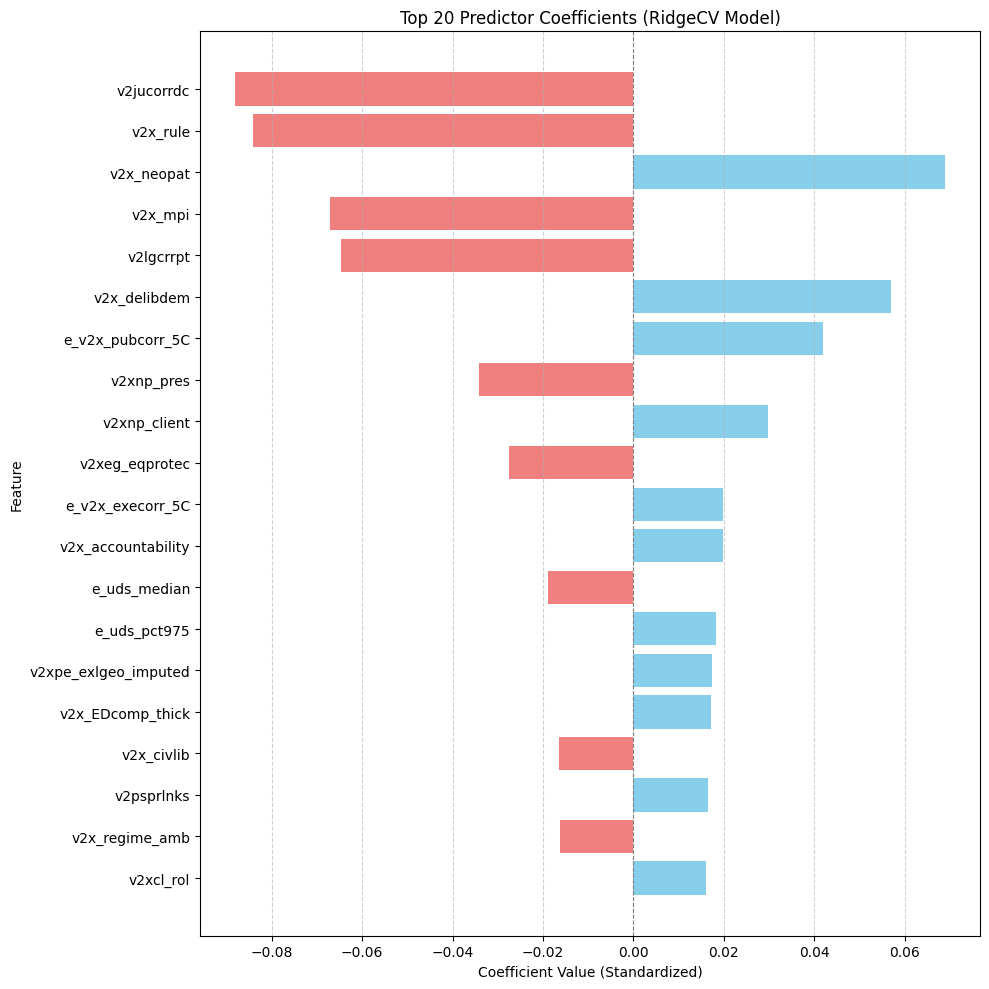


--- Script Finished ---


In [8]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Only import models needed for coefficient analysis
from sklearn.linear_model import RidgeCV, LassoCV

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- Steps 1-6: Data Loading, Preprocessing, Split, Standardize ---
# (Identical to the benchmark script setup - ensure consistency)

# 1. Load Data
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation (simplified for brevity)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)]
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed']
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 2 + df['feature_1'] * -1.5 + np.random.randn(n_samples) * 0.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    # Need other dummy columns if they are in the drop list
    df['e_v2x_corr_4C'] = pd.cut(df['v2x_corr'], bins=4, labels=False)
    df['v2x_delibdem_imputed'] = df['feature_4']

# 2. Define Target & Predictors, Drop Problematic Columns
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]

cols_to_drop_multicollinearity = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf","v2xnp_regcorr","v2x_execorr","v2x_pubcorr"
]
cols_to_drop_existing = [col for col in cols_to_drop_multicollinearity if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing))
predictors = [p for p in predictors if p not in cols_to_drop_final]

# 3. Log Transform GDP
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]

predictors = [p for p in predictors if p in df.columns]
print(f"Using {len(predictors)} final predictors.")
if not predictors: raise ValueError("No predictors left.")

# 4. Prepare Data: Select final columns & Split
X_pd = df[predictors]
y_pd = df[target]
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values

# 5. Standardize Features
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd) # Use the same scaler
print("Features standardized.")

# 6. Prepare MLX Data
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# --- Model Training and Coefficient Extraction ---

print("\n--- Training Models and Extracting Coefficients ---")

# 7. Train and Analyze RidgeCV (SKL)
print("\nProcessing: RidgeCV (SKL)")
ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_model.fit(X_train_np, y_train_np)
print(f"  RidgeCV Best Alpha: {ridge_model.alpha_:.4f}")
ridge_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': ridge_model.coef_
})
ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)


# 8. Train and Analyze LassoCV (SKL)
print("\nProcessing: LassoCV (SKL)")
lasso_model = LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
lasso_model.fit(X_train_np, y_train_np)
print(f"  LassoCV Best Alpha: {lasso_model.alpha_:.4f}")
lasso_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': lasso_model.coef_
})
lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
# Filter out zero coefficients before sorting for Lasso
lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features out of {len(predictors)}")


# 9. Train and Analyze MLX Linear Regression
print("\nProcessing: MLX Linear")
# Define MLX model class and training function (copied from benchmark script)
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    model.eval()
    return model

# Train the MLX model
num_features = X_train_np.shape[1]
mlx_model = train_mlx_model(X_train_mx, y_train_mx, num_features, epochs=500) # Use same epochs as benchmark maybe
print("  MLX Model Trained.")

# Extract MLX coefficients
mx.eval(mlx_model.linear.weight, mlx_model.linear.bias)
mlx_weights = np.array(mlx_model.linear.weight.squeeze())
mlx_bias = np.array(mlx_model.linear.bias)
mlx_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': mlx_weights
})
mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
mlx_coefs = mlx_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)


# --- Display Top Predictors ---

print("\n--- Top Predictors by Absolute Coefficient Magnitude ---")
N_TOP_FEATURES = 20 # How many top features to display

print(f"\n--- Top {N_TOP_FEATURES} Predictors for RidgeCV (SKL) ---")
print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False))

print(f"\n--- Top {N_TOP_FEATURES} (Non-Zero) Predictors for LassoCV (SKL) ---")
print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False))

print(f"\n--- Top {N_TOP_FEATURES} Predictors for MLX Linear ---")
print(mlx_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False))


# --- Visualize Coefficients (Example for RidgeCV) ---

print("\n--- Visualizing Top Predictor Coefficients (Example: RidgeCV) ---")

# Select top N features based on Ridge model for plotting
plot_data = ridge_coefs.head(N_TOP_FEATURES).sort_values('abs_coef') # Sort for plotting

plt.figure(figsize=(10, N_TOP_FEATURES / 2)) # Adjust figure size
colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
plt.xlabel("Coefficient Value (Standardized)")
plt.ylabel("Feature")
plt.title(f"Top {N_TOP_FEATURES} Predictor Coefficients (RidgeCV Model)")
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Dropped 47 columns (incl. direct corruption components).
Now using 311 predictors BEFORE log transform.
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 311 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking (Excluding Direct Corruption Vars) ---

Processing: MLX Linear
  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...
  MLX Training finished in 32.64 seconds.
  Test R²: 0.5988, Test RMSE: 0.1857

Processing: Linear Regression (SKL)
  SKL Training finished in 0.12 seconds.
  Test R²: 0.9901, Test RMSE: 0.0291

Processing: RidgeCV (SKL)
  SKL Training finished in 0.73 seconds.
  Test R²: 0.9901, Test RMSE: 0.0292

Proc

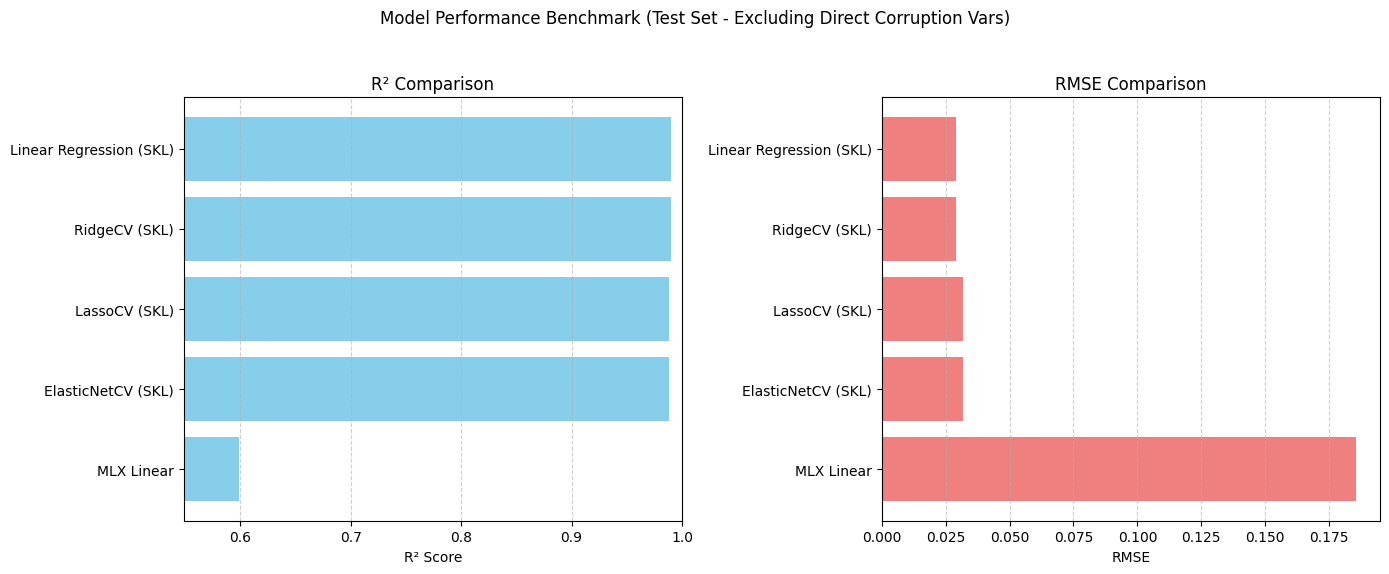


--- Script Finished ---


In [9]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import to check version

# Optional: Scipy for QQ plot if needed for specific model diagnostics later
from scipy import stats

# Ignore convergence warnings from LassoCV/ElasticNetCV for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation (same as before)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)]
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed', 'v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt',
                  'v2jucorrdc', 'v2exbribe', 'v2exembez', 'v2excrptps', 'v2exthftps'] # Include new dummies
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    # Weaken relationship for more realistic lower R2 in dummy data
    df['v2x_corr'] = df['feature_0'] * 0.5 + df['feature_1'] * -0.3 + np.random.randn(n_samples) * 1.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    # Add dummy versions of new variables
    for col in ['v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt', 'v2jucorrdc', 'v2exbribe',
                 'v2exembez', 'v2excrptps', 'v2exthftps']:
         df[col] = df['v2x_corr'] * (0.2 + 0.6*np.random.rand(n_samples)) + np.random.rand(n_samples)*0.1 # Correlate with target
    df['e_v2x_corr_4C'] = pd.cut(df['v2x_corr'], bins=4, labels=False) + np.random.rand(n_samples)*0.1
    df['v2x_polyarchy_imputed_rf'] = df['feature_3'] + np.random.rand(n_samples)*0.1
    df['v2x_delibdem_imputed'] = df['feature_4'] + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")

# --- MODIFICATION START ---
# Original list + New direct corruption component variables
cols_to_drop = [
    # Previously dropped (multicollinearity/tautology/imputation issues)
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",

    # NEW: Drop direct components/sub-components of v2x_corr based on codebook
    "v2x_pubcorr",  # Public sector corruption index
    "v2x_execorr",  # Executive corruption index
    "v2lgcrrpt",    # Legislative corruption
    "v2jucorrdc",   # Judicial corruption
    "v2exbribe",    # Executive bribery (sub-component)
    "v2exembez",    # Executive embezzlement (sub-component)
    "v2excrptps",   # Public sector bribery (sub-component)
    "v2exthftps",   # Public sector theft/embezzlement (sub-component)
]
# --- MODIFICATION END ---

cols_to_drop_existing = [col for col in cols_to_drop if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing)) # Ensure uniqueness
predictors = [p for p in predictors if p not in cols_to_drop_final]
print(f"Dropped {len(cols_to_drop_final)} columns (incl. direct corruption components).")
print(f"Now using {len(predictors)} predictors BEFORE log transform.")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
# Check if gdp_var wasn't dropped in the previous step
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_final: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")

predictors = [p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
X_pd = df[predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 7. ── Define MLX Linear Regression Model & Training Function ───────────────
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.")
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark = {
    "MLX Linear": None,
    "Linear Regression (SKL)": SkLinearRegression(),
    "RidgeCV (SKL)": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV (SKL)": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001),
    "ElasticNetCV (SKL)": ElasticNetCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
}
# Ensure num_features reflects the reduced set
num_features = X_train_np.shape[1]
if num_features <= 0:
    raise ValueError("No features left after dropping columns.")


# 9. ── Run Benchmark Loop ───────────────────────────────────────────────────
print("\n--- Starting Model Benchmarking (Excluding Direct Corruption Vars) ---")
benchmark_results = []

for name, model in models_to_benchmark.items():
    print(f"\nProcessing: {name}")
    preds_np = None
    training_time = None

    try:
        if name == "MLX Linear":
            trained_mlx_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500
            )
            preds_mx = trained_mlx_model(X_test_mx)
            mx.eval(preds_mx)
            preds_np = np.array(preds_mx).flatten()
        else:
            start_time = time.time()
            model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  SKL Training finished in {training_time:.2f} seconds.")
            preds_np = model.predict(X_test_np)

        r2 = r2_score(y_test_np, preds_np)
        mse = mean_squared_error(y_test_np, preds_np)
        rmse = np.sqrt(mse)
        print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

    except Exception as e:
        print(f"  ERROR processing {name}: {e}")
        benchmark_results.append({
            "Model": name,
            "Test R²": np.nan,
            "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })


# 10. ── Display Results ─────────────────────────────────────────────────────
print("\n--- Benchmark Results (Excluding Direct Corruption Vars) ---")
results_df = pd.DataFrame(benchmark_results)
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No benchmark results were generated.")


# 11. ── Plot Results ────────────────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Benchmark (Test Set - Excluding Direct Corruption Vars)')

    plot_df_r2 = results_df.dropna(subset=['Test R²']).sort_values("Test R²")
    plot_df_rmse = results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE", ascending=False)

    if not plot_df_r2.empty:
        axes[0].barh(plot_df_r2["Model"], plot_df_r2["Test R²"], color='skyblue')
        axes[0].set_xlabel("R² Score")
        axes[0].set_title("R² Comparison")
        # Adjust xlim for potentially lower R2 values
        min_r2 = plot_df_r2["Test R²"].min()
        axes[0].set_xlim(left=max(-0.1, min_r2 - 0.05), right=1.0) # Allow slightly negative R2
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")

    if not plot_df_rmse.empty:
        axes[1].barh(plot_df_rmse["Model"], plot_df_rmse["Test RMSE"], color='lightcoral')
        axes[1].set_xlabel("RMSE")
        axes[1].set_title("RMSE Comparison")
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


print("\n--- Script Finished ---")

Data shape: (9129, 363)
Dropped 47 columns (incl. direct corruption components).
Using 311 final predictors.
Features standardized.

--- Training Models (Excluding Direct Corruption Vars) and Extracting Coefficients ---

Processing: RidgeCV (SKL)
  RidgeCV Best Alpha: 1.0000

Processing: LassoCV (SKL)
  LassoCV Best Alpha: 0.0003
  LassoCV selected 129 non-zero features out of 311

Processing: MLX Linear
  MLX Model Trained.

--- Top Predictors by Absolute Coefficient Magnitude (Excluding Direct Corruption Vars) ---

--- Top 20 Predictors for RidgeCV (SKL) ---
         feature  coefficient
   v2xnp_regcorr       0.3104
e_v2x_execorr_5C      -0.0727
      v2x_neopat       0.0658
      v2x_civlib      -0.0617
      v2x_libdem      -0.0507
e_v2x_pubcorr_5C       0.0435
e_v2x_execorr_4C      -0.0426
     v2x_liberal       0.0421
    v2x_delibdem       0.0383
       v2xcl_rol       0.0350
    e_uds_median      -0.0298
     v2xcl_acjst      -0.0295
      v2xnp_pres      -0.0267
    e_uds_pct

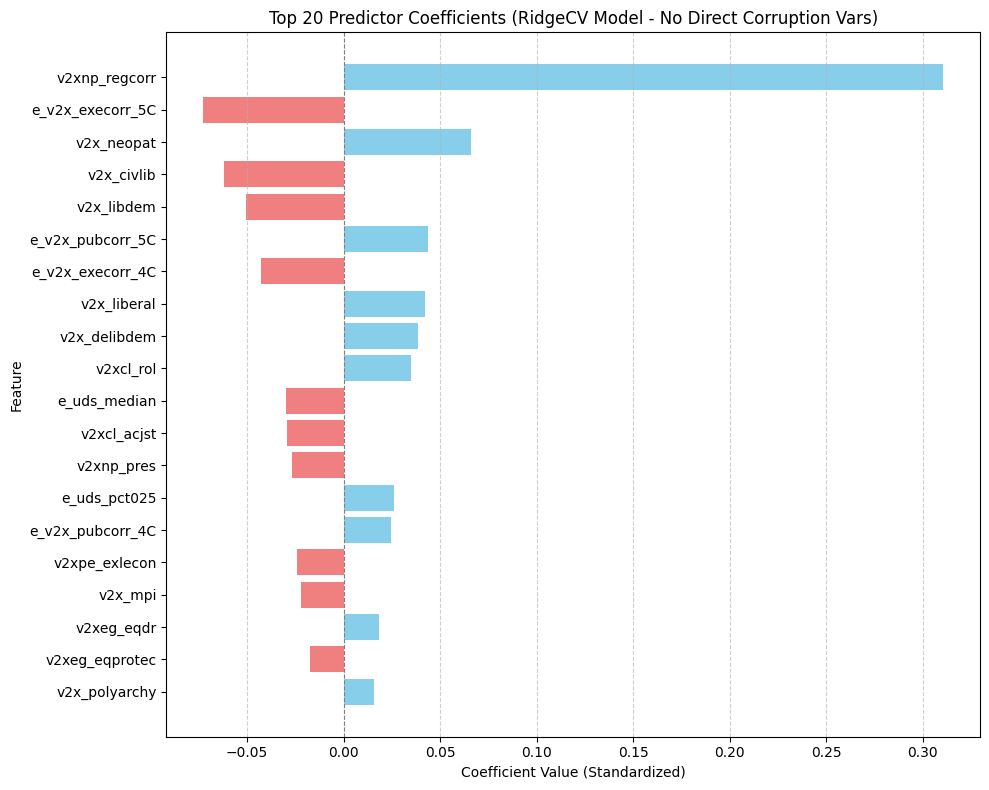


--- Script Finished ---


In [10]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV # Only needed models

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- Steps 1-6: Data Loading, Preprocessing, Split, Standardize ---
# (Matching the LATEST benchmark script setup)

# 1. Load Data
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation (matching latest benchmark)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)]
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed', 'v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt',
                  'v2jucorrdc', 'v2exbribe', 'v2exembez', 'v2excrptps', 'v2exthftps']
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 0.5 + df['feature_1'] * -0.3 + np.random.randn(n_samples) * 1.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    for col in ['v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt', 'v2jucorrdc', 'v2exbribe',
                 'v2exembez', 'v2excrptps', 'v2exthftps', 'e_v2x_corr_4C',
                 'v2x_polyarchy_imputed_rf','v2x_delibdem_imputed']:
         if col in df.columns: # Ensure col exists before dummy assignment
              df[col] = df['feature_0'] * (0.2 + 0.6*np.random.rand(n_samples)) + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. Define Target & Predictors, Drop Problematic Columns (INCLUDING CORRUPTION COMPONENTS)
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]

# Combine ALL columns to drop
cols_to_drop = [
    # Previously dropped
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf","v2xnp_regcorr", "e_v2x_execorr_5C"
    # Direct corruption components/sub-components
    "v2x_pubcorr", "v2x_execorr", "v2lgcrrpt", "v2jucorrdc",
    "v2exbribe", "v2exembez", "v2excrptps", "v2exthftps",
]
cols_to_drop_existing = [col for col in cols_to_drop if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing))
predictors = [p for p in predictors if p not in cols_to_drop_final]
print(f"Dropped {len(cols_to_drop_final)} columns (incl. direct corruption components).")

# 3. Log Transform GDP
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]

predictors = [p for p in predictors if p in df.columns]
print(f"Using {len(predictors)} final predictors.")
if not predictors: raise ValueError("No predictors left.")

# 4. Prepare Data: Select final columns & Split
X_pd = df[predictors]
y_pd = df[target]
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
y_train_np = y_train_pd.values

# 5. Standardize Features
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
# X_test_np = scaler.transform(X_test_pd) # Test set not needed for coefficients
print("Features standardized.")

# 6. Prepare MLX Data
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# --- Model Training and Coefficient Extraction ---

print("\n--- Training Models (Excluding Direct Corruption Vars) and Extracting Coefficients ---")

# 7. Train and Analyze RidgeCV (SKL)
print("\nProcessing: RidgeCV (SKL)")
ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_model.fit(X_train_np, y_train_np)
print(f"  RidgeCV Best Alpha: {ridge_model.alpha_:.4f}")
ridge_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': ridge_model.coef_
})
ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)


# 8. Train and Analyze LassoCV (SKL)
print("\nProcessing: LassoCV (SKL)")
lasso_model = LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
lasso_model.fit(X_train_np, y_train_np)
print(f"  LassoCV Best Alpha: {lasso_model.alpha_:.4f}")
lasso_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': lasso_model.coef_
})
lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features out of {len(predictors)}")


# 9. Train and Analyze MLX Linear Regression
print("\nProcessing: MLX Linear")
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    model.eval()
    return model

num_features = X_train_np.shape[1]
mlx_model = train_mlx_model(X_train_mx, y_train_mx, num_features, epochs=500)
print("  MLX Model Trained.")

mx.eval(mlx_model.linear.weight, mlx_model.linear.bias)
mlx_weights = np.array(mlx_model.linear.weight.squeeze())
# mlx_bias = np.array(mlx_model.linear.bias) # Bias not needed for feature importance
mlx_coefs = pd.DataFrame({
    'feature': predictors,
    'coefficient': mlx_weights
})
mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
mlx_coefs = mlx_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)


# --- Display Top Predictors ---

print("\n--- Top Predictors by Absolute Coefficient Magnitude (Excluding Direct Corruption Vars) ---")
N_TOP_FEATURES = 20 # How many top features to display

print(f"\n--- Top {N_TOP_FEATURES} Predictors for RidgeCV (SKL) ---")
print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))

print(f"\n--- Top {N_TOP_FEATURES} (Non-Zero) Predictors for LassoCV (SKL) ---")
if not lasso_coefs_nonzero.empty:
    print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
else:
    print("  LassoCV selected 0 features.")


print(f"\n--- Top {N_TOP_FEATURES} Predictors for MLX Linear ---")
print(mlx_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))


# --- Visualize Coefficients (Example for RidgeCV) ---

print("\n--- Visualizing Top Predictor Coefficients (Example: RidgeCV - Excluding Direct Corruption Vars) ---")

if not ridge_coefs.empty:
    plot_data = ridge_coefs.head(N_TOP_FEATURES).sort_values('abs_coef') # Sort for plotting

    plt.figure(figsize=(10, max(6, N_TOP_FEATURES / 2.5))) # Adjust figure size
    colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
    plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES} Predictor Coefficients (RidgeCV Model - No Direct Corruption Vars)")
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping RidgeCV plot: No coefficients found.")

print("\n--- Script Finished ---")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Dropped 47 columns (incl. direct corruption components).
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 311 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking (Excluding Direct Corruption Vars) ---

Processing: MLX Linear
  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...
  MLX Training finished in 30.73 seconds.
  Test R²: 0.9432, Test RMSE: 0.0699

Processing: Linear Regression (SKL)
  SKL Training finished in 0.11 seconds.
  Test R²: 0.9901, Test RMSE: 0.0291

Processing: RidgeCV (SKL)
  SKL Training finished in 0.77 seconds.
  Test R²: 0.9901, Test RMSE: 0.0292

Processing: LassoCV (SKL)
  SKL Training finished i

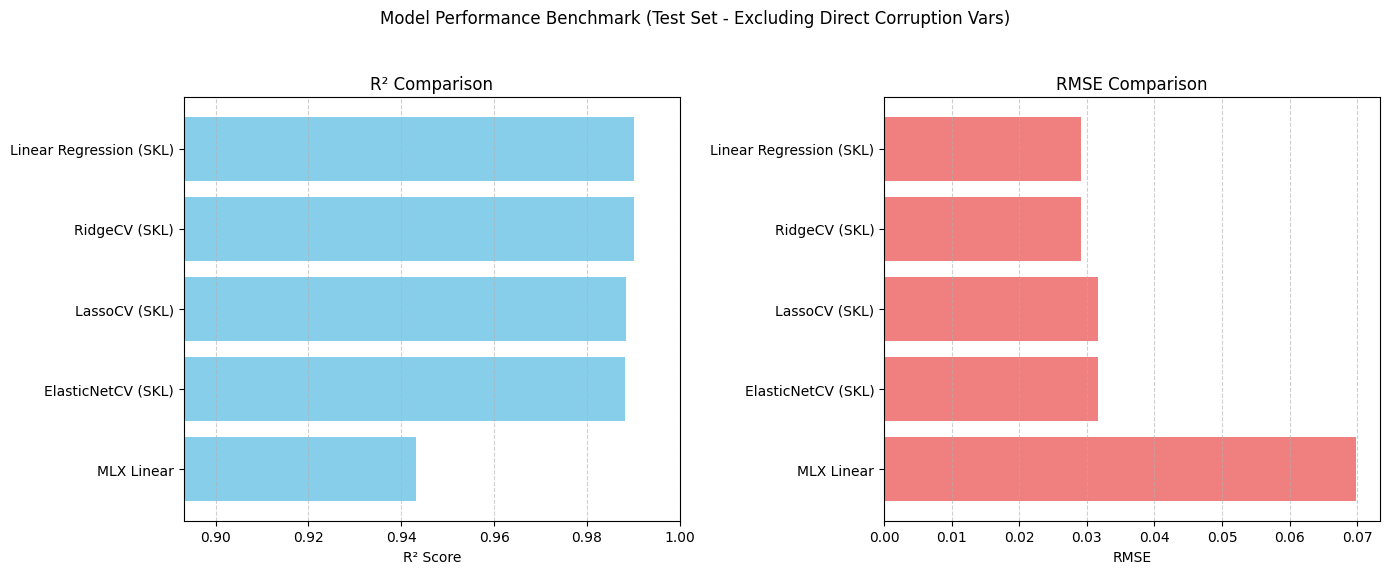


--- Analyzing Coefficients from Selected Models ---

Processing Coefficients: RidgeCV (SKL)
--- Top 20 Predictors for RidgeCV (SKL) ---
         feature  coefficient
   v2xnp_regcorr       0.3104
e_v2x_execorr_5C      -0.0727
      v2x_neopat       0.0658
      v2x_civlib      -0.0617
      v2x_libdem      -0.0507
e_v2x_pubcorr_5C       0.0435
e_v2x_execorr_4C      -0.0426
     v2x_liberal       0.0421
    v2x_delibdem       0.0383
       v2xcl_rol       0.0350
    e_uds_median      -0.0298
     v2xcl_acjst      -0.0295
      v2xnp_pres      -0.0267
    e_uds_pct025       0.0260
e_v2x_pubcorr_4C       0.0243
   v2xpe_exlecon      -0.0242
         v2x_mpi      -0.0223
      v2xeg_eqdr       0.0183
  v2xeg_eqprotec      -0.0173
   v2x_polyarchy       0.0157

Processing Coefficients: LassoCV (SKL)
  LassoCV selected 129 non-zero features.
--- Top 20 (Non-Zero) Predictors for LassoCV (SKL) ---
         feature  coefficient
   v2xnp_regcorr       0.3276
e_v2x_execorr_5C      -0.0728
e_v2x_

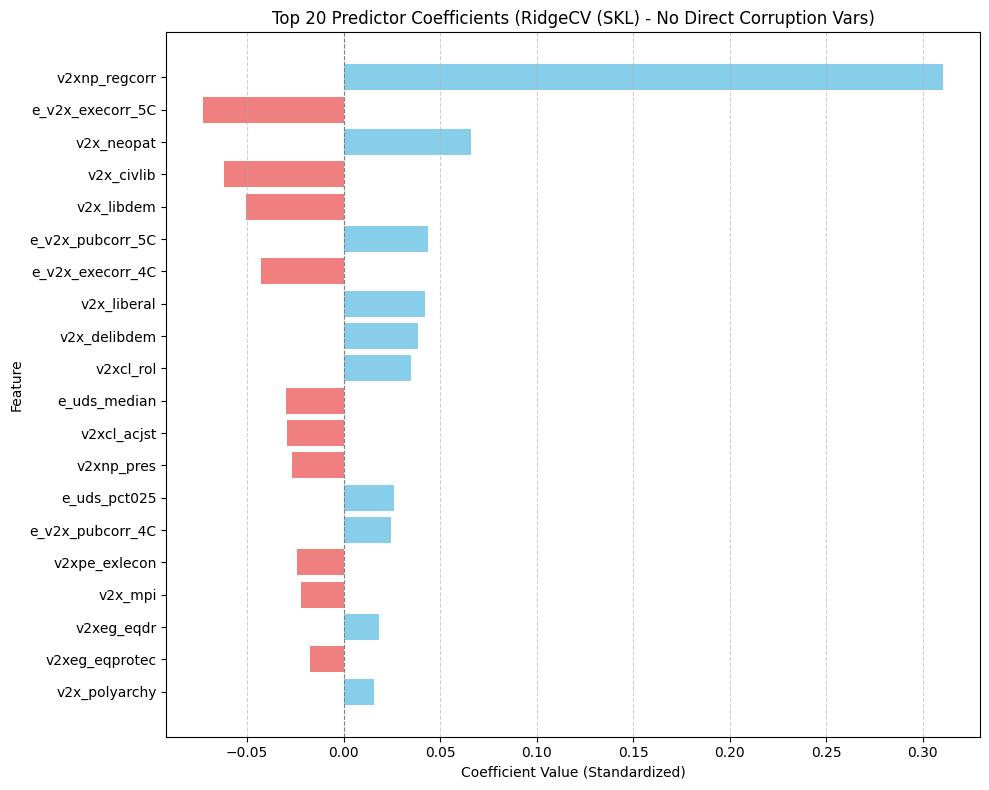


--- Script Finished ---


In [11]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import to check version

# Optional: Scipy for QQ plot if needed for specific model diagnostics later
from scipy import stats

# Ignore convergence warnings from LassoCV/ElasticNetCV for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    df = pd.read_csv("../temp/df_imputed.csv")
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data for demonstration.")
    # Dummy data generation (matching latest benchmark)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)]
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed', 'v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt',
                  'v2jucorrdc', 'v2exbribe', 'v2exembez', 'v2excrptps', 'v2exthftps']
    all_cols = feature_names + extra_cols
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 0.5 + df['feature_1'] * -0.3 + np.random.randn(n_samples) * 1.5
    df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    for col in ['v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt', 'v2jucorrdc', 'v2exbribe',
                 'v2exembez', 'v2excrptps', 'v2exthftps', 'e_v2x_corr_4C',
                 'v2x_polyarchy_imputed_rf','v2x_delibdem_imputed']:
         if col in df.columns: # Ensure col exists before dummy assignment
              df[col] = df['feature_0'] * (0.2 + 0.6*np.random.rand(n_samples)) + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")

# Combine ALL columns to drop (Previous + Direct Corruption Components)
cols_to_drop = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",
    "v2x_pubcorr", "v2x_execorr", "v2lgcrrpt", "v2jucorrdc",
    "v2exbribe", "v2exembez", "v2excrptps", "v2exthftps",
]
cols_to_drop_existing = [col for col in cols_to_drop if col in predictors]
cols_to_drop_final = list(set(cols_to_drop_existing))
predictors = [p for p in predictors if p not in cols_to_drop_final]
print(f"Dropped {len(cols_to_drop_final)} columns (incl. direct corruption components).")

# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_final: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")

predictors = [p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
X_pd = df[predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 7. ── Define MLX Linear Regression Model & Training Function ───────────────
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.")
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark = {
    "MLX Linear": None, # Placeholder, trained in loop
    "Linear Regression (SKL)": SkLinearRegression(),
    "RidgeCV (SKL)": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV (SKL)": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001),
    "ElasticNetCV (SKL)": ElasticNetCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
}
num_features = X_train_np.shape[1]
if num_features <= 0: raise ValueError("No features left after dropping.")


# 9. ── Run Benchmark Loop & Store Trained Models ────────────────────────────
print("\n--- Starting Model Benchmarking (Excluding Direct Corruption Vars) ---")
benchmark_results = []
# --- Store trained models needed for coefficient analysis ---
trained_models = {}
# ---

for name, model_instance in models_to_benchmark.items():
    print(f"\nProcessing: {name}")
    preds_np = None
    training_time = None
    current_trained_model = None # To store the model trained in this iteration

    try:
        if name == "MLX Linear":
            # Train MLX and store the returned model
            current_trained_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500
            )
            # Predict using the trained MLX model
            preds_mx = current_trained_model(X_test_mx)
            mx.eval(preds_mx)
            preds_np = np.array(preds_mx).flatten()
        else:
            # Use the instance from the dictionary for SKL models
            current_trained_model = model_instance
            start_time = time.time()
            current_trained_model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  SKL Training finished in {training_time:.2f} seconds.")
            preds_np = current_trained_model.predict(X_test_np)

        # Evaluate
        r2 = r2_score(y_test_np, preds_np)
        mse = mean_squared_error(y_test_np, preds_np)
        rmse = np.sqrt(mse)
        print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

        # --- Store the trained model if needed later ---
        if name in ["RidgeCV (SKL)", "LassoCV (SKL)", "MLX Linear"]:
             trained_models[name] = current_trained_model
        # ---

    except Exception as e:
        print(f"  ERROR processing {name}: {e}")
        benchmark_results.append({
            "Model": name,
            "Test R²": np.nan,
            "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })


# 10. ── Display Benchmark Results ───────────────────────────────────────────
print("\n--- Benchmark Results (Excluding Direct Corruption Vars) ---")
results_df = pd.DataFrame(benchmark_results)
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No benchmark results were generated.")


# 11. ── Plot Benchmark Results ───────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Model Performance Benchmark (Test Set - Excluding Direct Corruption Vars)')
    plot_df_r2 = results_df.dropna(subset=['Test R²']).sort_values("Test R²")
    plot_df_rmse = results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE", ascending=False)

    if not plot_df_r2.empty:
        axes[0].barh(plot_df_r2["Model"], plot_df_r2["Test R²"], color='skyblue')
        axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison")
        min_r2 = plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1, min_r2 - 0.05), right=1.0)
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")

    if not plot_df_rmse.empty:
        axes[1].barh(plot_df_rmse["Model"], plot_df_rmse["Test RMSE"], color='lightcoral')
        axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison")
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 12. ── Extract and Analyze Coefficients from Stored Models ─────────────────
print("\n--- Analyzing Coefficients from Selected Models ---")
N_TOP_FEATURES = 20 # How many top features to display
all_coef_dfs = {} # To store coefficient dataframes

# Analyze RidgeCV
model_name = "RidgeCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    ridge_model = trained_models[model_name]
    ridge_coefs = pd.DataFrame({
        'feature': predictors,
        'coefficient': ridge_model.coef_
    })
    ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
    ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = ridge_coefs
    print(f"--- Top {N_TOP_FEATURES} Predictors for {model_name} ---")
    print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
else:
    print(f"\n{model_name} not found in trained models for coefficient analysis.")

# Analyze LassoCV
model_name = "LassoCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    lasso_model = trained_models[model_name]
    lasso_coefs = pd.DataFrame({
        'feature': predictors,
        'coefficient': lasso_model.coef_
    })
    lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
    lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
    lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = lasso_coefs_nonzero # Store non-zero coefficients
    print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features.")
    print(f"--- Top {N_TOP_FEATURES} (Non-Zero) Predictors for {model_name} ---")
    if not lasso_coefs_nonzero.empty:
        print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
    else:
        print("  LassoCV selected 0 features.")
else:
    print(f"\n{model_name} not found in trained models for coefficient analysis.")

# Analyze MLX Linear
model_name = "MLX Linear"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    mlx_model_trained = trained_models[model_name]
    mx.eval(mlx_model_trained.linear.weight) # Ensure computation
    mlx_weights = np.array(mlx_model_trained.linear.weight.squeeze())
    if len(predictors) == len(mlx_weights): # Check consistency
        mlx_coefs = pd.DataFrame({
            'feature': predictors,
            'coefficient': mlx_weights
        })
        mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
        mlx_coefs = mlx_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
        all_coef_dfs[model_name] = mlx_coefs
        print(f"--- Top {N_TOP_FEATURES} Predictors for {model_name} ---")
        print(mlx_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
    else:
        print(f"  ERROR: Mismatch between predictor count ({len(predictors)}) and MLX weights ({len(mlx_weights)}).")
else:
    print(f"\n{model_name} not found in trained models for coefficient analysis.")


# 13. ── Visualize Top Coefficients (Example: RidgeCV) ───────────────────────
print("\n--- Visualizing Top Predictor Coefficients (Example: RidgeCV - Excluding Direct Corruption Vars) ---")
model_to_plot = "RidgeCV (SKL)"
if model_to_plot in all_coef_dfs and not all_coef_dfs[model_to_plot].empty:
    plot_data = all_coef_dfs[model_to_plot].head(N_TOP_FEATURES).sort_values('abs_coef')
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES / 2.5)))
    colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
    plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES} Predictor Coefficients ({model_to_plot} - No Direct Corruption Vars)")
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping coefficient plot: No data found for {model_to_plot}.")


print("\n--- Script Finished ---")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Found 14 predictors containing 'corr': ['v2jucorrdc', 'v2mecorrpt', 'v2xnp_regcorr', 'v2x_pubcorr', 'v2x_execorr', 'e_v2x_pubcorr_3C', 'e_v2x_pubcorr_4C', 'e_v2x_pubcorr_5C', 'e_v2x_execorr_3C', 'e_v2x_execorr_4C', 'e_v2x_execorr_5C', 'e_v2x_corr_3C', 'e_v2x_corr_4C', 'e_v2x_corr_5C']
Dropped 55 columns (manual list + 'corr' containing).
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 303 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking (Excluding ALL 'corr' Vars) ---

Processing: MLX Linear
  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...
  MLX Training finished in 22.05 seconds.
  Test R²: 0.9297, Test RMSE: 0.0

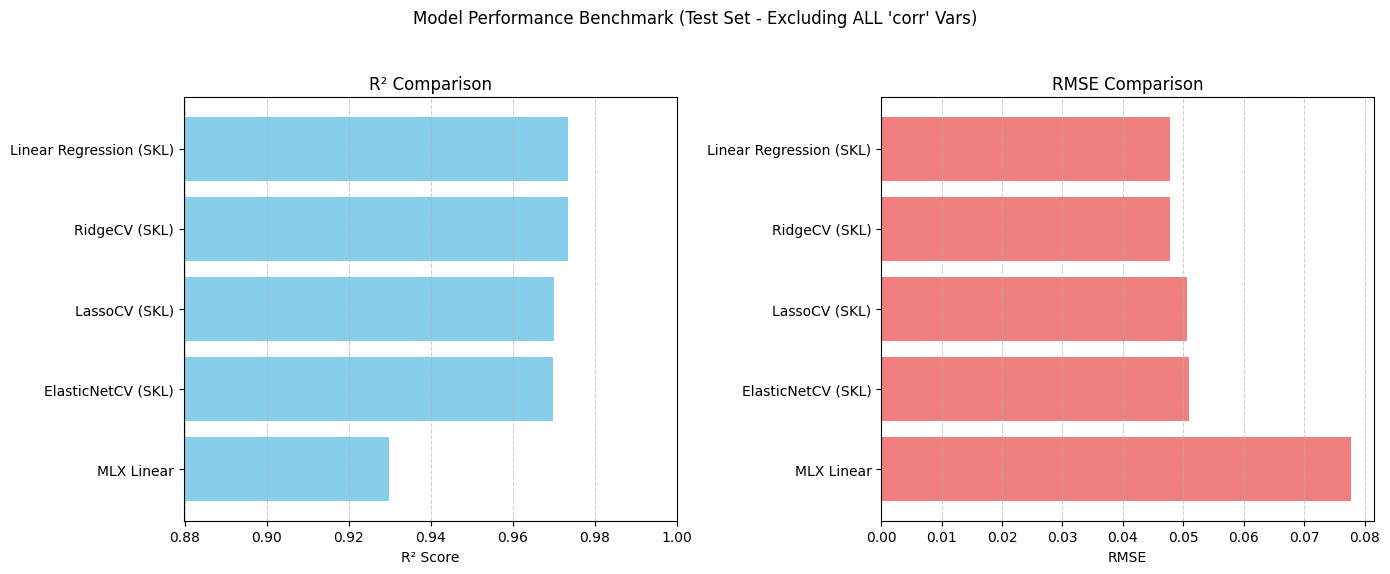


--- Analyzing Coefficients (Excluding ALL 'corr' Vars) ---

Processing Coefficients: RidgeCV (SKL)
--- Top 20 Predictors for RidgeCV (SKL) ---
           feature  coefficient
          v2x_rule      -0.3232
        v2x_neopat       0.2634
        v2x_civlib      -0.2039
         v2xcl_rol       0.1748
         v2x_jucon       0.1514
        v2xnp_pres      -0.1224
       v2x_egaldem       0.0929
v2x_accountability       0.0829
           v2x_mpi      -0.0627
     v2x_polyarchy      -0.0544
        v2x_libdem      -0.0533
         v2x_clphy       0.0529
  v2x_EDcomp_thick       0.0498
      e_uds_pct025       0.0427
       v2xcl_acjst      -0.0424
     v2xpe_exlecon      -0.0415
      v2xlg_legcon       0.0412
    v2xeg_eqprotec      -0.0369
      e_uds_median      -0.0358
        e_wbgi_cce      -0.0326

Processing Coefficients: LassoCV (SKL)
  LassoCV selected 183 non-zero features.
--- Top 20 (Non-Zero) Predictors for LassoCV (SKL) ---
                  feature  coefficient
        

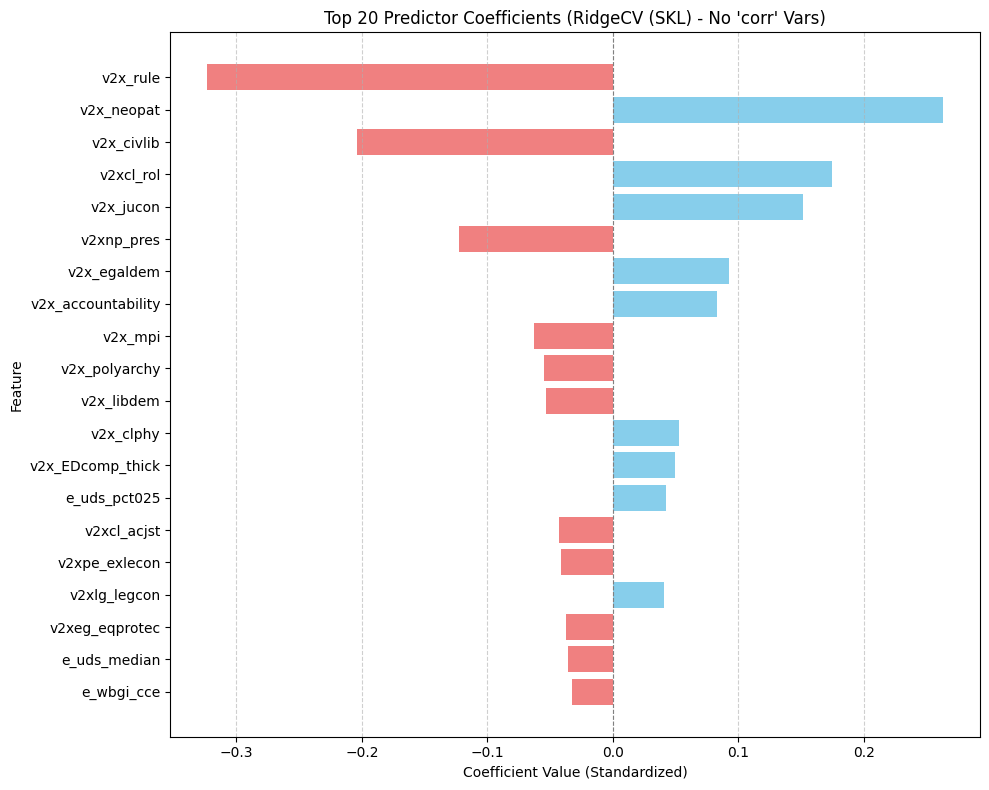


--- Script Finished ---


In [12]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import to check version

# Optional: Scipy for QQ plot
from scipy import stats

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    df = pd.read_csv("../temp/df_imputed.csv")
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)] + ['some_correlation_measure']
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed', 'v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt',
                  'v2jucorrdc', 'v2exbribe', 'v2exembez', 'v2excrptps', 'v2exthftps']
    all_cols = list(set(feature_names + extra_cols)) # Use set to avoid duplicates if names overlap
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr'] = df['feature_0'] * 0.5 + df['feature_1'] * -0.3 + np.random.randn(n_samples) * 1.5
    if 'e_gdppc_imputed_rf' in df.columns: df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    for col in ['v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt', 'v2jucorrdc', 'v2exbribe',
                 'v2exembez', 'v2excrptps', 'v2exthftps', 'e_v2x_corr_4C',
                 'v2x_polyarchy_imputed_rf','v2x_delibdem_imputed', 'some_correlation_measure']:
         if col in df.columns:
              df[col] = df['feature_0'] * (0.2 + 0.6*np.random.rand(n_samples)) + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Initial predictors: numeric cols excluding base non-predictors
predictors = [c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")

# --- MODIFICATION START: Identify & Combine ALL columns to drop ---
# 1. Manually specified problematic/component columns
manual_drop_cols = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",
    "v2x_pubcorr", "v2x_execorr", "v2lgcrrpt", "v2jucorrdc",
    "v2exbribe", "v2exembez", "v2excrptps", "v2exthftps",
]

# 2. Identify columns containing "corr" (case-insensitive) among current predictors
corr_containing_cols = [p for p in predictors if "corr" in p.lower()]
print(f"Found {len(corr_containing_cols)} predictors containing 'corr': {corr_containing_cols}")

# 3. Combine all columns to drop
cols_to_drop = list(set(manual_drop_cols + corr_containing_cols)) # Use set for uniqueness

# 4. Filter the predictor list
cols_to_drop_existing = [col for col in cols_to_drop if col in predictors]
predictors = [p for p in predictors if p not in cols_to_drop_existing]
print(f"Dropped {len(cols_to_drop_existing)} columns (manual list + 'corr' containing).")
# --- MODIFICATION END ---

# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns: # Check if GDP var survived the drop
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_existing: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")

predictors = [p for p in predictors if p in df.columns] # Final check for existence
if not predictors: raise ValueError("No valid predictor columns remain after all filtering.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
X_pd = df[predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 7. ── Define MLX Linear Regression Model & Training Function ───────────────
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.")
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark = {
    "MLX Linear": None,
    "Linear Regression (SKL)": SkLinearRegression(),
    "RidgeCV (SKL)": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV (SKL)": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001),
    "ElasticNetCV (SKL)": ElasticNetCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
}
num_features = X_train_np.shape[1]
if num_features <= 0: raise ValueError("No features left after dropping.")


# 9. ── Run Benchmark Loop & Store Trained Models ────────────────────────────
print("\n--- Starting Model Benchmarking (Excluding ALL 'corr' Vars) ---") # Updated Title
benchmark_results = []
trained_models = {}

for name, model_instance in models_to_benchmark.items():
    print(f"\nProcessing: {name}")
    preds_np = None
    training_time = None
    current_trained_model = None

    try:
        if name == "MLX Linear":
            current_trained_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500
            )
            preds_mx = current_trained_model(X_test_mx)
            mx.eval(preds_mx)
            preds_np = np.array(preds_mx).flatten()
        else:
            current_trained_model = model_instance
            start_time = time.time()
            current_trained_model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  SKL Training finished in {training_time:.2f} seconds.")
            preds_np = current_trained_model.predict(X_test_np)

        r2 = r2_score(y_test_np, preds_np)
        mse = mean_squared_error(y_test_np, preds_np)
        rmse = np.sqrt(mse)
        print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

        if name in ["RidgeCV (SKL)", "LassoCV (SKL)", "MLX Linear"]:
             trained_models[name] = current_trained_model

    except Exception as e:
        print(f"  ERROR processing {name}: {e}")
        benchmark_results.append({
            "Model": name,
            "Test R²": np.nan,
            "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })


# 10. ── Display Benchmark Results ───────────────────────────────────────────
print("\n--- Benchmark Results (Excluding ALL 'corr' Vars) ---") # Updated Title
results_df = pd.DataFrame(benchmark_results)
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No benchmark results were generated.")


# 11. ── Plot Benchmark Results ───────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Model Performance Benchmark (Test Set - Excluding ALL 'corr' Vars)") # Updated Title
    plot_df_r2 = results_df.dropna(subset=['Test R²']).sort_values("Test R²")
    plot_df_rmse = results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE", ascending=False)

    if not plot_df_r2.empty:
        axes[0].barh(plot_df_r2["Model"], plot_df_r2["Test R²"], color='skyblue')
        axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison")
        min_r2 = plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1, min_r2 - 0.05), right=1.0)
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")

    if not plot_df_rmse.empty:
        axes[1].barh(plot_df_rmse["Model"], plot_df_rmse["Test RMSE"], color='lightcoral')
        axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison")
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 12. ── Extract and Analyze Coefficients from Stored Models ─────────────────
print("\n--- Analyzing Coefficients (Excluding ALL 'corr' Vars) ---") # Updated Title
N_TOP_FEATURES = 20
all_coef_dfs = {}

# Analyze RidgeCV
model_name = "RidgeCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    ridge_model = trained_models[model_name]
    ridge_coefs = pd.DataFrame({'feature': predictors,'coefficient': ridge_model.coef_})
    ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
    ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = ridge_coefs
    print(f"--- Top {N_TOP_FEATURES} Predictors for {model_name} ---")
    print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
else: print(f"\n{model_name} not found for coefficient analysis.")

# Analyze LassoCV
model_name = "LassoCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    lasso_model = trained_models[model_name]
    lasso_coefs = pd.DataFrame({'feature': predictors, 'coefficient': lasso_model.coef_})
    lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
    lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
    lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = lasso_coefs_nonzero
    print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features.")
    print(f"--- Top {N_TOP_FEATURES} (Non-Zero) Predictors for {model_name} ---")
    if not lasso_coefs_nonzero.empty:
        print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
    else: print("  LassoCV selected 0 features.")
else: print(f"\n{model_name} not found for coefficient analysis.")

# Analyze MLX Linear
model_name = "MLX Linear"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    mlx_model_trained = trained_models[model_name]
    mx.eval(mlx_model_trained.linear.weight)
    mlx_weights = np.array(mlx_model_trained.linear.weight.squeeze())
    if len(predictors) == len(mlx_weights):
        mlx_coefs = pd.DataFrame({'feature': predictors,'coefficient': mlx_weights})
        mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
        mlx_coefs = mlx_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
        all_coef_dfs[model_name] = mlx_coefs
        print(f"--- Top {N_TOP_FEATURES} Predictors for {model_name} ---")
        print(mlx_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
    else: print(f"  ERROR: Mismatch predictor count ({len(predictors)}) vs MLX weights ({len(mlx_weights)}).")
else: print(f"\n{model_name} not found for coefficient analysis.")


# 13. ── Visualize Top Coefficients (Example: RidgeCV) ───────────────────────
print("\n--- Visualizing Top Predictor Coefficients (Example: RidgeCV - Excluding ALL 'corr' Vars) ---") # Updated Title
model_to_plot = "RidgeCV (SKL)"
if model_to_plot in all_coef_dfs and not all_coef_dfs[model_to_plot].empty:
    plot_data = all_coef_dfs[model_to_plot].head(N_TOP_FEATURES).sort_values('abs_coef')
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES / 2.5)))
    colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
    plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES} Predictor Coefficients ({model_to_plot} - No 'corr' Vars)") # Updated Title
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping coefficient plot: No data found for {model_to_plot}.")


print("\n--- Script Finished ---")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Found 3 participation predictors present in the dataset:

['v2x_partip', 'v2x_cspart', 'v2csgender', 'v2csprtcpt', 'v2pscnslnl', 'v2xdd_dd', 'v2ddadmci', 'v2ddadmrf', 'v2ddapprci', 'v2ddapprrf', 'v2ddlexci', 'v2ddlexrf', 'v2ddsigdci', 'v2ddsigdrf', 'v2ddsiglci', 'v2ddsigpci', 'v2ddsigprf', 'v2ddpartci', 'v2ddpartrf', 'v2ddspmci', 'v2ddspmrf', 'v2ddthreci', 'v2ddyrci', 'v2ddadmor', 'v2ddadmpl', 'v2ddappor', 'v2ddapprpl', 'v2ddlexor', 'v2ddlexpl', 'v2ddpartor', 'v2ddpartpl', 'v2ddspmor', 'v2ddspmpl', 'v2ddthreor', 'v2ddthrepl', 'v2ddthrerf', 'v2ddyror', 'v2ddyrpl', 'v2ddyrrf', 'v2xel_locelec', 'v2ellocelc', 'v2ellocgov', 'v2ellocpwr', 'v2xel_regelec', 'v2elreggov', 'v2elrgpwr', 'v2elsrge']

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Participation Features ---
Standardization complete.

--- Training and Evaluating Models using Participation Predicto

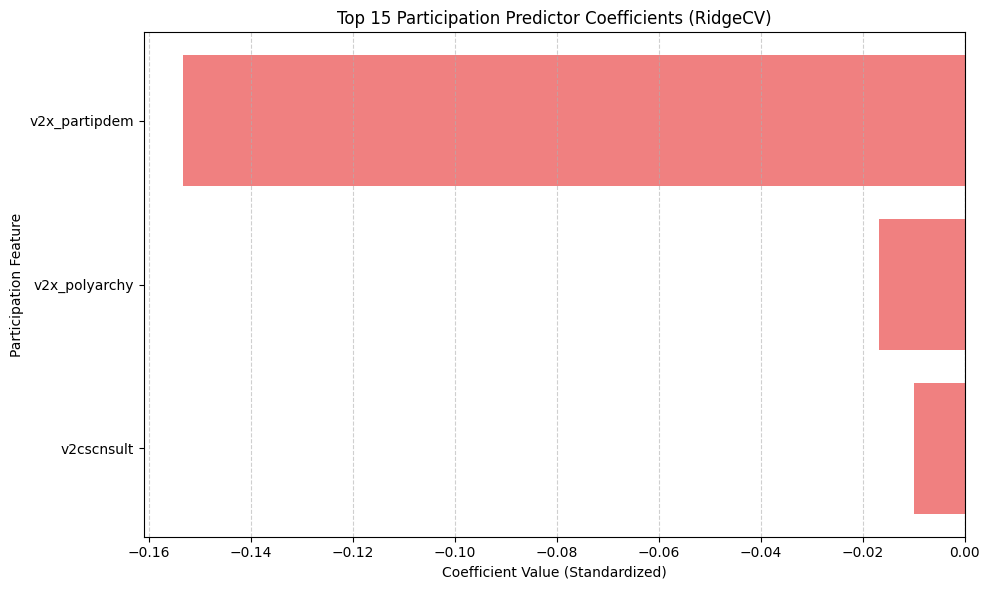


--- Hypothesis Test Script Finished ---


In [13]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV # Focus models for this hypothesis
from sklearn.metrics import r2_score, mean_squared_error
import sklearn # Import to check version

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading ─────────────────────────────────────────────────────────
try:
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    df = pd.read_csv("../temp/df_imputed.csv")
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation - Must include target and some participation vars
    n_samples = 1000
    participation_vars_dummy = [
        'v2x_partipdem', 'v2x_polyarchy', 'v2x_cspart', 'v2cscnsult',
        'v2xdd_dd', 'v2xel_locelec', 'v2ellocelc', 'v2xel_regelec', 'v2elsrge'
    ]
    other_cols = ['country_name', 'country_id', 'year', 'v2x_corr']
    all_cols = list(set(participation_vars_dummy + other_cols)) # Use set for unique names
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    # Make target somewhat related to some participation vars for dummy data
    df['v2x_corr'] = df['v2x_polyarchy'] * 0.3 - df['v2x_cspart'] * 0.2 + np.random.randn(n_samples) * 0.1
    # Fill object columns
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target and SPECIFIC Participatory Predictors ───────────────
target = "v2x_corr"

# List extracted carefully from the provided codebook text
participation_predictors_full = [
    'v2x_partipdem', 'v2x_polyarchy', 'v2x_partip', 'v2x_cspart',
    'v2cscnsult', 'v2csgender', 'v2csprtcpt', 'v2pscnslnl',
    'v2xdd_dd', 'v2ddadmci', 'v2ddadmrf', 'v2ddapprci', 'v2ddapprrf',
    'v2ddlexci', 'v2ddlexrf', 'v2ddsigdci', 'v2ddsigdrf', 'v2ddsiglci',
    'v2ddsigpci', 'v2ddsigprf', 'v2ddpartci', 'v2ddpartrf', 'v2ddspmci',
    'v2ddspmrf', 'v2ddthreci', 'v2ddyrci', 'v2ddadmor', 'v2ddadmpl',
    'v2ddappor', 'v2ddapprpl', 'v2ddlexor', 'v2ddlexpl', 'v2ddpartor',
    'v2ddpartpl', 'v2ddspmor', 'v2ddspmpl', 'v2ddthreor', 'v2ddthrepl',
    'v2ddthrerf', 'v2ddyror', 'v2ddyrpl', 'v2ddyrrf',
    'v2xel_locelec', 'v2ellocelc', 'v2ellocgov', 'v2ellocpwr',
    'v2xel_regelec', 'v2elreggov', 'v2elrgpwr', 'v2elsrge'
]

# Ensure target variable exists
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in DataFrame.")

# Filter the list to include only predictors actually present in the DataFrame
participation_predictors = [p for p in participation_predictors_full if p in df.columns]
print(f"Found {len(participation_predictors)} participation predictors present in the dataset:")
# print(participation_predictors) # Uncomment to see the exact list used

dropped_predictors = [p for p in participation_predictors_full if p not in df.columns]
if dropped_predictors:
    print(f"\nWarning: The following {len(dropped_predictors)} specified participation predictors were NOT found and will be excluded:")
    print(dropped_predictors)

if not participation_predictors:
    raise ValueError("No participation predictors found in the DataFrame. Cannot proceed.")


# 3. ── Prepare Data: Select final columns & Split ─────────────────────────
# Use ONLY the participation predictors
X_pd = df[participation_predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 4. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Participation Features ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete.")


# 5. ── Train and Evaluate Models ────────────────────────────────────────────
print("\n--- Training and Evaluating Models using Participation Predictors ---")
models_to_evaluate = {
    "RidgeCV": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001)
}
evaluation_results = []
trained_participation_models = {}

for name, model in models_to_evaluate.items():
    print(f"\nProcessing: {name}")
    start_time = time.time()
    model.fit(X_train_np, y_train_np)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Training finished in {training_time:.2f} seconds.")

    # Predict on test set
    preds_np = model.predict(X_test_np)

    # Evaluate
    r2 = r2_score(y_test_np, preds_np)
    mse = mean_squared_error(y_test_np, preds_np)
    rmse = np.sqrt(mse)
    print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

    evaluation_results.append({
        "Model": name,
        "Test R²": r2,
        "Test RMSE": rmse,
        "Training Time (s)": training_time
    })
    trained_participation_models[name] = model # Store the trained model


# 6. ── Display Evaluation Results ──────────────────────────────────────────
print("\n--- Evaluation Results (Predicting Corruption with Participation Vars) ---")
results_df = pd.DataFrame(evaluation_results)
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No evaluation results were generated.")


# 7. ── Extract and Analyze Coefficients ───────────────────────────────────
print("\n--- Analyzing Coefficients for Participation Predictors ---")
N_TOP_FEATURES = 15 # Adjust as needed
all_coef_dfs = {}

# Analyze RidgeCV
model_name = "RidgeCV"
if model_name in trained_participation_models:
    print(f"\nProcessing Coefficients: {model_name}")
    ridge_model = trained_participation_models[model_name]
    print(f"  RidgeCV Best Alpha: {ridge_model.alpha_:.4f}")
    ridge_coefs = pd.DataFrame({
        'feature': participation_predictors, # Use the filtered list
        'coefficient': ridge_model.coef_
    })
    ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
    ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = ridge_coefs
    print(f"--- Top {N_TOP_FEATURES} Participation Predictors for {model_name} ---")
    print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
else:
    print(f"\n{model_name} not found in trained models.")

# Analyze LassoCV
model_name = "LassoCV"
if model_name in trained_participation_models:
    print(f"\nProcessing Coefficients: {model_name}")
    lasso_model = trained_participation_models[model_name]
    print(f"  LassoCV Best Alpha: {lasso_model.alpha_:.4f}")
    lasso_coefs = pd.DataFrame({
        'feature': participation_predictors, # Use the filtered list
        'coefficient': lasso_model.coef_
    })
    lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
    lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
    lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    all_coef_dfs[model_name] = lasso_coefs_nonzero
    print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features out of {len(participation_predictors)}.")
    print(f"--- Top {N_TOP_FEATURES} (Non-Zero) Participation Predictors for {model_name} ---")
    if not lasso_coefs_nonzero.empty:
        print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES).to_string(index=False, float_format="%.4f"))
    else:
        print("  LassoCV selected 0 features.")
else:
    print(f"\n{model_name} not found in trained models.")


# 8. ── Visualize Top Coefficients (Example: RidgeCV) ───────────────────────
print("\n--- Visualizing Top Participation Predictor Coefficients (Example: RidgeCV) ---")
model_to_plot = "RidgeCV"
if model_to_plot in all_coef_dfs and not all_coef_dfs[model_to_plot].empty:
    plot_data = all_coef_dfs[model_to_plot].head(N_TOP_FEATURES).sort_values('abs_coef')
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES / 2.5)))
    colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
    plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Participation Feature")
    plt.title(f"Top {N_TOP_FEATURES} Participation Predictor Coefficients ({model_to_plot})")
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping coefficient plot: No data found for {model_to_plot}.")


print("\n--- Hypothesis Test Script Finished ---")

In [14]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Linear Models
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# Non-Linear Models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
# Metrics & Version
from sklearn.metrics import r2_score, mean_squared_error
import sklearn

# Optional: Scipy for QQ plot
from scipy import stats

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings('ignore', category=ConvergenceWarning) # Might be needed for older sklearn

# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    df = pd.read_csv("../temp/df_imputed.csv")
    # --- !!! IMPORTANT: Ensure this path is correct !!! ---
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    # Dummy data generation (less correlated for potentially better non-linear showcase)
    n_samples = 1000
    n_features = 50
    feature_names = [f'feature_{i}' for i in range(n_features)] + ['some_correlation_measure']
    extra_cols = ['country_name', 'country_text_id', 'country_id', 'year', 'v2x_corr',
                  'e_gdppc_imputed_rf', 'e_v2x_corr_4C', 'v2x_polyarchy_imputed_rf',
                  'v2x_delibdem_imputed', 'v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt',
                  'v2jucorrdc', 'v2exbribe', 'v2exembez', 'v2excrptps', 'v2exthftps']
    all_cols = list(set(feature_names + extra_cols))
    df = pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    # Add some non-linearity for dummy data
    df['v2x_corr'] = (np.sin(df['feature_0'] * np.pi) * 0.5 +
                      df['feature_1'] * -0.3 +
                      np.square(df['feature_2']) * 0.2 +
                      np.random.randn(n_samples) * 0.5)
    if 'e_gdppc_imputed_rf' in df.columns: df['e_gdppc_imputed_rf'] = np.exp(df['feature_2'] * 3 + 10)
    for col in ['v2x_pubcorr', 'v2x_execorr', 'v2lgcrrpt', 'v2jucorrdc', 'v2exbribe',
                 'v2exembez', 'v2excrptps', 'v2exthftps', 'e_v2x_corr_4C',
                 'v2x_polyarchy_imputed_rf','v2x_delibdem_imputed', 'some_correlation_measure']:
         if col in df.columns:
              df[col] = df['feature_0'] * (0.2 + 0.6*np.random.rand(n_samples)) + np.random.rand(n_samples)*0.1
    df['country_name'] = [f'Country_{i%10}' for i in range(n_samples)]
    df['country_text_id'] = [f'C{i%10}' for i in range(n_samples)]
    df['country_id'] = [i%10 for i in range(n_samples)]
    df['year'] = [2000 + i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target = "v2x_corr"
base_drop_cols = ["country_name", "country_text_id", "country_id", "year", target]
base_drop_cols = [col for col in base_drop_cols if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
predictors = [c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")

# Combine ALL columns to drop (Manual + Direct Corruption + 'corr' containing)
manual_drop_cols = [
    "e_v2x_corr_3C", "e_v2x_corr_4C", "e_v2x_corr_5C", "v2x_delibdem_imputed",
    "v2xel_frefair_imputed", "v2xdl_delib_imputed", "e_v2xdl_delib_4C_imputed",
    "e_v2xdl_delib_5C_imputed", "e_v2x_delibdem_3C_imputed", "e_v2x_delibdem_4C_imputed",
    "e_v2x_delibdem_5C_imputed", "e_v2xel_frefair_3C_imputed", "e_v2xel_frefair_4C_imputed",
    "e_v2xel_frefair_5C_imputed", "v2clpolcl_imputed_rf", "v2peasjsoecon_imputed_rf",
    "v2peapsgen_imputed_rf", "v2peasjgen_imputed_rf", "v2xpe_exlecon_imputed_rf",
    "v2x_polyarchy_imputed_rf", "v2x_libdem_imputed_rf", "v2x_partipdem_imputed_rf",
    "v2x_egaldem_imputed_rf", "v2x_mpi_imputed_rf", "v2x_liberal_imputed_rf",
    "v2x_regime_imputed_rf", "v2x_regime_amb_imputed_rf", "v2x_EDcomp_thick_imputed_rf",
    "e_v2x_egaldem_3C_imputed_rf", "e_v2x_egaldem_4C_imputed_rf", "e_v2x_egaldem_5C_imputed_rf",
    "e_v2x_libdem_3C_imputed_rf", "e_v2x_libdem_4C_imputed_rf", "e_v2x_libdem_5C_imputed_rf",
    "e_v2x_mpi_5C_imputed_rf", "e_v2x_EDcomp_thick_5C_imputed_rf", "e_v2x_liberal_4C_imputed_rf",
    "e_v2x_liberal_5C_imputed_rf", "e_v2x_polyarchy_5C_imputed_rf",
    "v2x_pubcorr", "v2x_execorr", "v2lgcrrpt", "v2jucorrdc",
    "v2exbribe", "v2exembez", "v2excrptps", "v2exthftps",
]
corr_containing_cols = [p for p in predictors if "corr" in p.lower()]
print(f"Found {len(corr_containing_cols)} predictors containing 'corr'.") # Removed list for brevity
cols_to_drop = list(set(manual_drop_cols + corr_containing_cols))
cols_to_drop_existing = [col for col in cols_to_drop if col in predictors]
predictors = [p for p in predictors if p not in cols_to_drop_existing]
print(f"Dropped {len(cols_to_drop_existing)} columns (manual list + 'corr' containing).")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var = "e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val = df[gdp_var].min()
    if min_val <= 0:
        offset = -min_val + 1e-6
        print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.")
        df["log_gdppc"] = np.log(df[gdp_var] + offset)
    else: df["log_gdppc"] = np.log(df[gdp_var])
    predictors = [p for p in predictors if p != gdp_var] + ["log_gdppc"]
    print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_existing: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")

predictors = [p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
X_pd = df[predictors]
y_pd = df[target]

print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.20, random_state=42
)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np = y_train_pd.values
y_test_np = y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_pd)
X_test_np = scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32)
X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 7. ── Define MLX Linear Regression Model & Training Function ───────────────
# (Keep MLX Linear definition and training function as before)
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    start_time = time.time()
    model.train()
    # Simplified training loop for brevity in example
    for epoch in range(epochs):
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.")
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark (Including Non-Linear Models) ────────────
# --- MODIFICATION START ---
models_to_benchmark = {
    # Linear Models
    "MLX Linear": None, # Placeholder
    "Linear Regression (SKL)": SkLinearRegression(),
    "RidgeCV (SKL)": RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5),
    "LassoCV (SKL)": LassoCV(cv=5, random_state=42, max_iter=5000, tol=0.001),
    "ElasticNetCV (SKL)": ElasticNetCV(cv=5, random_state=42, max_iter=5000, tol=0.001),

    # Non-Linear Models
    "Random Forest (SKL)": RandomForestRegressor(n_estimators=100, # A reasonable default
                                                  random_state=42,
                                                  n_jobs=-1), # Use all available cores
    "Hist Gradient Boosting (SKL)": HistGradientBoostingRegressor(random_state=42),
    "SVR (RBF Kernel - SKL)": SVR() # Uses RBF kernel by default
}
# --- MODIFICATION END ---

num_features = X_train_np.shape[1]
if num_features <= 0: raise ValueError("No features left after dropping.")


# 9. ── Run Benchmark Loop & Store Trained Models ────────────────────────────
print("\n--- Starting Model Benchmarking (Including Non-Linear Models) ---")
benchmark_results = []
trained_models = {} # Store models needed later (Linear + Trees for Importance)

for name, model_instance in models_to_benchmark.items():
    print(f"\nProcessing: {name}")
    preds_np = None
    training_time = None
    current_trained_model = None

    try:
        if name == "MLX Linear":
            current_trained_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500
            )
            preds_mx = current_trained_model(X_test_mx)
            mx.eval(preds_mx)
            preds_np = np.array(preds_mx).flatten()
        else:
            # Use the instance from the dictionary for SKL models
            current_trained_model = model_instance
            start_time = time.time()
            # Note: SVR can be slow on larger datasets
            current_trained_model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  SKL Training finished in {training_time:.2f} seconds.")
            preds_np = current_trained_model.predict(X_test_np)

        # Evaluate
        r2 = r2_score(y_test_np, preds_np)
        mse = mean_squared_error(y_test_np, preds_np)
        rmse = np.sqrt(mse)
        print(f"  Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

        # Store models needed for importance/coefficient analysis
        if name in ["RidgeCV (SKL)", "LassoCV (SKL)", "MLX Linear",
                    "Random Forest (SKL)", "Hist Gradient Boosting (SKL)"]:
             trained_models[name] = current_trained_model

    except Exception as e:
        print(f"  ERROR processing {name}: {e}")
        benchmark_results.append({
            "Model": name,
            "Test R²": np.nan,
            "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })


# 10. ── Display Benchmark Results ───────────────────────────────────────────
print("\n--- Benchmark Results (Including Non-Linear Models) ---")
results_df = pd.DataFrame(benchmark_results)
if not results_df.empty:
    results_df = results_df.sort_values(by="Test R²", ascending=False).reset_index(drop=True)
    print(results_df.to_string(index=False, float_format="%.4f"))
else:
    print("No benchmark results were generated.")


# 11. ── Plot Benchmark Results ───────────────────────────────────────────────
# (Code remains the same as before, but will now include new models)
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Slightly larger height
    fig.suptitle("Model Performance Benchmark (Test Set - Excl. 'corr' Vars)")
    plot_df_r2 = results_df.dropna(subset=['Test R²']).sort_values("Test R²")
    plot_df_rmse = results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE", ascending=False)

    if not plot_df_r2.empty:
        axes[0].barh(plot_df_r2["Model"], plot_df_r2["Test R²"], color='skyblue')
        axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison")
        min_r2 = plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1, min_r2 - 0.05), right=1.0)
        axes[0].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")

    if not plot_df_rmse.empty:
        axes[1].barh(plot_df_rmse["Model"], plot_df_rmse["Test RMSE"], color='lightcoral')
        axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison")
        axes[1].grid(axis='x', linestyle='--', alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 12. ── Extract and Analyze Linear Model Coefficients ──────────────────────
print("\n--- Analyzing Coefficients from Linear Models ---")
N_TOP_FEATURES_LINEAR = 15 # Show fewer for linear models maybe
linear_coef_dfs = {}

# Analyze RidgeCV
model_name = "RidgeCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    ridge_model = trained_models[model_name]
    ridge_coefs = pd.DataFrame({'feature': predictors,'coefficient': ridge_model.coef_})
    ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
    ridge_coefs = ridge_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    linear_coef_dfs[model_name] = ridge_coefs
    print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---")
    print(ridge_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False, float_format="%.4f"))
else: print(f"\n{model_name} not found for coefficient analysis.")

# Analyze LassoCV
model_name = "LassoCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    lasso_model = trained_models[model_name]
    lasso_coefs = pd.DataFrame({'feature': predictors, 'coefficient': lasso_model.coef_})
    lasso_coefs['abs_coef'] = lasso_coefs['coefficient'].abs()
    lasso_coefs_nonzero = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
    lasso_coefs_nonzero = lasso_coefs_nonzero.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    linear_coef_dfs[model_name] = lasso_coefs_nonzero
    print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features.")
    print(f"--- Top {N_TOP_FEATURES_LINEAR} (Non-Zero) Predictors for {model_name} ---")
    if not lasso_coefs_nonzero.empty:
        print(lasso_coefs_nonzero[['feature', 'coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False, float_format="%.4f"))
    else: print("  LassoCV selected 0 features.")
else: print(f"\n{model_name} not found for coefficient analysis.")

# Analyze MLX Linear
model_name = "MLX Linear"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    mlx_model_trained = trained_models[model_name]
    mx.eval(mlx_model_trained.linear.weight)
    mlx_weights = np.array(mlx_model_trained.linear.weight.squeeze())
    if len(predictors) == len(mlx_weights):
        mlx_coefs = pd.DataFrame({'feature': predictors,'coefficient': mlx_weights})
        mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
        mlx_coefs = mlx_coefs.sort_values('abs_coef', ascending=False).reset_index(drop=True)
        linear_coef_dfs[model_name] = mlx_coefs
        print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---")
        print(mlx_coefs[['feature', 'coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False, float_format="%.4f"))
    else: print(f"  ERROR: Mismatch predictor count ({len(predictors)}) vs MLX weights ({len(mlx_weights)}).")
else: print(f"\n{model_name} not found for coefficient analysis.")


# --- NEW SECTION: Extract and Analyze Tree Model Feature Importances ---
print("\n--- Analyzing Feature Importances from Tree-Based Models ---")
N_TOP_FEATURES_TREE = 20 # Show potentially more for tree models
tree_importance_dfs = {}

# Analyze Random Forest
model_name = "Random Forest (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Feature Importances: {model_name}")
    rf_model = trained_models[model_name]
    rf_importances = pd.DataFrame({
        'feature': predictors,
        'importance': rf_model.feature_importances_
    })
    rf_importances = rf_importances.sort_values('importance', ascending=False).reset_index(drop=True)
    tree_importance_dfs[model_name] = rf_importances
    print(f"--- Top {N_TOP_FEATURES_TREE} Features for {model_name} ---")
    print(rf_importances.head(N_TOP_FEATURES_TREE).to_string(index=False, float_format="%.4f"))
else:
    print(f"\n{model_name} not found for importance analysis.")

# Analyze Hist Gradient Boosting
model_name = "Hist Gradient Boosting (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Feature Importances: {model_name}")
    # Need to calculate permutation importance for HistGradientBoostingRegressor as it doesn't have .feature_importances_ directly
    # This adds computational cost, so we'll do it only if needed and requested.
    # For simplicity here, we'll skip the importance calculation for HistGBM
    # If required, look into `sklearn.inspection.permutation_importance`
    print(f"  Feature importance extraction for {model_name} requires permutation_importance (skipped in this example).")
    # Example using permutation importance (would replace the print above):
    # from sklearn.inspection import permutation_importance
    # print(f"  Calculating Permutation Importance for {model_name} (may take time)...")
    # hgbm_model = trained_models[model_name]
    # perm_importance = permutation_importance(hgbm_model, X_test_np, y_test_np, n_repeats=10, random_state=42, n_jobs=-1)
    # hgbm_importances = pd.DataFrame({
    #     'feature': predictors,
    #     'importance_mean': perm_importance.importances_mean,
    #     'importance_std': perm_importance.importances_std
    # })
    # hgbm_importances = hgbm_importances.sort_values('importance_mean', ascending=False).reset_index(drop=True)
    # tree_importance_dfs[model_name] = hgbm_importances
    # print(f"--- Top {N_TOP_FEATURES_TREE} Features for {model_name} (Permutation Importance Mean) ---")
    # print(hgbm_importances[['feature', 'importance_mean']].head(N_TOP_FEATURES_TREE).to_string(index=False, float_format="%.4f"))

else:
    print(f"\n{model_name} not found for importance analysis.")


# 13. ── Visualize Coefficients & Importances ───────────────────────────────

# Visualize Linear Coefficients (Example: RidgeCV)
print("\n--- Visualizing Top Linear Predictor Coefficients (Example: RidgeCV) ---")
model_to_plot_lin = "RidgeCV (SKL)"
if model_to_plot_lin in linear_coef_dfs and not linear_coef_dfs[model_to_plot_lin].empty:
    plot_data = linear_coef_dfs[model_to_plot_lin].head(N_TOP_FEATURES_LINEAR).sort_values('abs_coef')
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES_LINEAR / 2.5)))
    colors = ['lightcoral' if c < 0 else 'skyblue' for c in plot_data['coefficient']]
    plt.barh(plot_data['feature'], plot_data['coefficient'], color=colors)
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES_LINEAR} Predictor Coefficients ({model_to_plot_lin} - No 'corr' Vars)")
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping linear coefficient plot: No data found for {model_to_plot_lin}.")


# Visualize Tree Feature Importances (Example: Random Forest)
print("\n--- Visualizing Top Tree Feature Importances (Example: Random Forest) ---")
model_to_plot_tree = "Random Forest (SKL)"
if model_to_plot_tree in tree_importance_dfs and not tree_importance_dfs[model_to_plot_tree].empty:
    plot_data = tree_importance_dfs[model_to_plot_tree].head(N_TOP_FEATURES_TREE).sort_values('importance')
    plt.figure(figsize=(10, max(6, N_TOP_FEATURES_TREE / 2.5)))
    plt.barh(plot_data['feature'], plot_data['importance'], color='lightgreen')
    plt.xlabel("Feature Importance Score (Gini importance or similar)")
    plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES_TREE} Feature Importances ({model_to_plot_tree} - No 'corr' Vars)")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping tree importance plot: No data found for {model_to_plot_tree}.")


print("\n--- Script Finished ---")

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Found 14 predictors containing 'corr'.
Dropped 55 columns (manual list + 'corr' containing).
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 303 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking (Including Non-Linear Models) ---

Processing: MLX Linear
  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...


KeyboardInterrupt: 

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially.
Found 14 predictors containing 'corr'.
Dropped 55 columns (manual list + 'corr' containing).
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 303 final predictors for the models.

--- Splitting Data (80% Train / 20% Test) ---
Train set: 7303, Test set: 1826

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete. Data is now in NumPy format.

--- Starting Model Benchmarking (Including Non-Linear Models) ---


Benchmarking Models:   0%|                                                    | 0/8 [00:00<?, ?it/s]

  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...


    MLX Epochs:   0%|                                                       | 0/500 [00:00<?, ?it/s]

  MLX Training finished in 26.99 seconds.
  Predicting with MLX Linear...
  MLX Linear prediction finished in 0.00 seconds.
  Evaluating MLX Linear...
  MLX Linear Results -> Test R²: 0.8378, Test RMSE: 0.1181
  Training Linear Regression (SKL)...
  Linear Regression (SKL) Training finished in 0.10 seconds.
  Predicting with Linear Regression (SKL)...
  Linear Regression (SKL) prediction finished in 0.00 seconds.
  Evaluating Linear Regression (SKL)...
  Linear Regression (SKL) Results -> Test R²: 0.9734, Test RMSE: 0.0478
  Training RidgeCV (SKL)...
  RidgeCV (SKL) Training finished in 0.82 seconds.
  Predicting with RidgeCV (SKL)...
  RidgeCV (SKL) prediction finished in 0.00 seconds.
  Evaluating RidgeCV (SKL)...
  RidgeCV (SKL) Results -> Test R²: 0.9734, Test RMSE: 0.0478
  Training LassoCV (SKL)...
  LassoCV (SKL) Training finished in 4.49 seconds.
  Predicting with LassoCV (SKL)...
  LassoCV (SKL) prediction finished in 0.00 seconds.
  Evaluating LassoCV (SKL)...
  LassoCV (SKL)

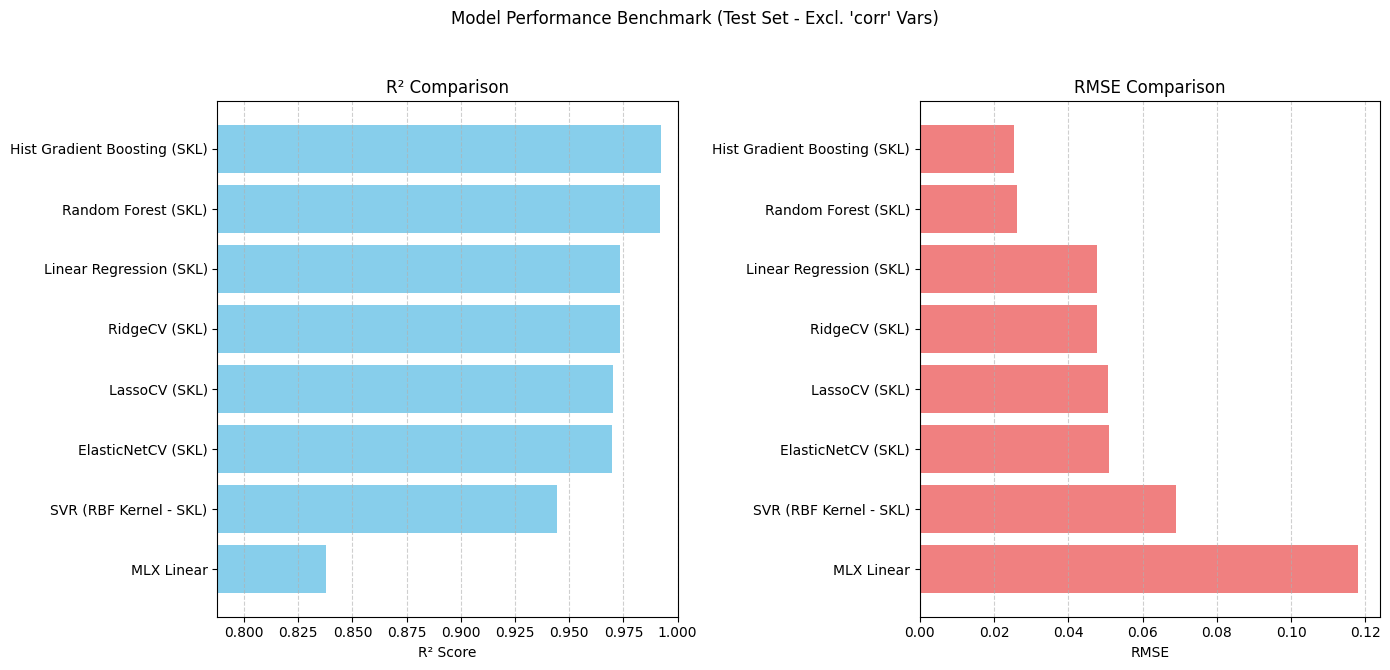


--- Analyzing Coefficients from Linear Models ---

Processing Coefficients: RidgeCV (SKL)
--- Top 15 Predictors for RidgeCV (SKL) ---
           feature  coefficient
          v2x_rule      -0.3232
        v2x_neopat       0.2634
        v2x_civlib      -0.2039
         v2xcl_rol       0.1748
         v2x_jucon       0.1514
        v2xnp_pres      -0.1224
       v2x_egaldem       0.0929
v2x_accountability       0.0829
           v2x_mpi      -0.0627
     v2x_polyarchy      -0.0544
        v2x_libdem      -0.0533
         v2x_clphy       0.0529
  v2x_EDcomp_thick       0.0498
      e_uds_pct025       0.0427
       v2xcl_acjst      -0.0424

Processing Coefficients: LassoCV (SKL)
  LassoCV selected 183 non-zero features.
--- Top 15 (Non-Zero) Predictors for LassoCV (SKL) ---
                  feature  coefficient
                 v2x_rule      -0.3225
               v2x_neopat       0.2124
                v2x_jucon       0.1050
               v2xnp_pres      -0.0825
                v2xcl

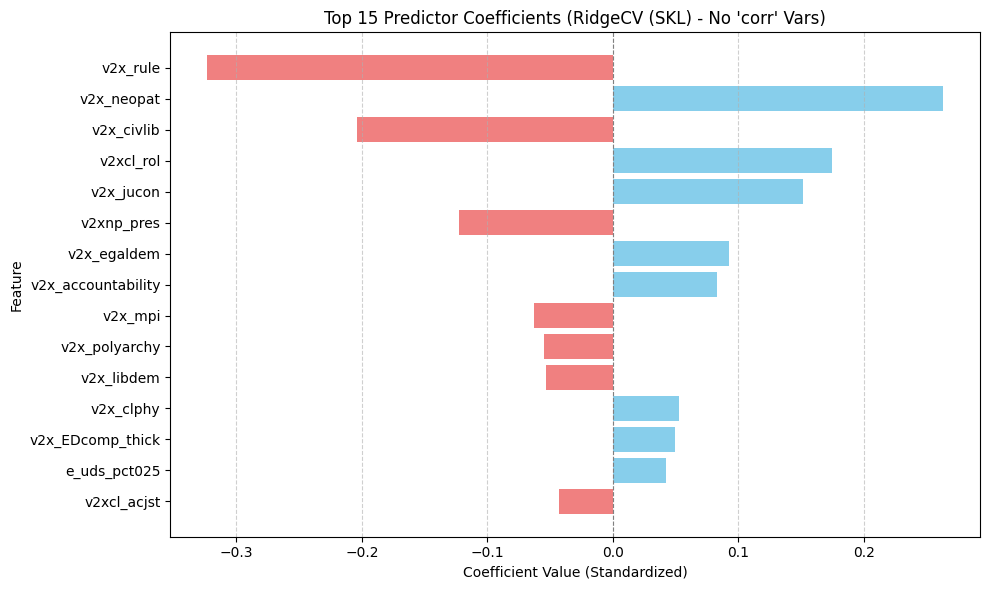


--- Visualizing Top Tree Feature Importances (Example: Random Forest) ---


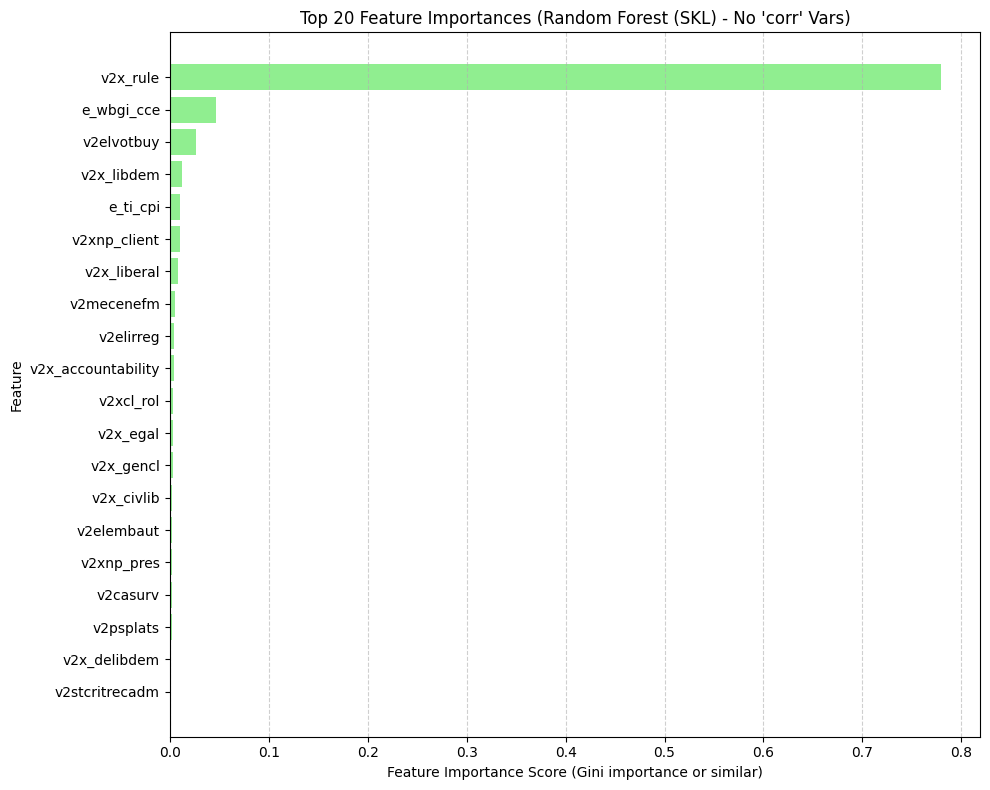


--- Script Finished ---


In [1]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# --- Add tqdm import ---
from tqdm.auto import tqdm # Auto-detects notebook or console environment
# ---

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Linear Models
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# Non-Linear Models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
# Metrics & Version
from sklearn.metrics import r2_score, mean_squared_error
import sklearn

# Optional: Scipy for QQ plot
from scipy import stats

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
# (Keep this section exactly as before)
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    n_samples=1000; n_features=50
    feature_names = [f'feature_{i}' for i in range(n_features)] + ['some_correlation_measure']
    extra_cols = ['country_name','country_text_id','country_id','year','v2x_corr','e_gdppc_imputed_rf','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps']
    all_cols=list(set(feature_names + extra_cols)); df=pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr']=(np.sin(df['feature_0']*np.pi)*0.5+df['feature_1']*-0.3+np.square(df['feature_2'])*0.2+np.random.randn(n_samples)*0.5)
    if 'e_gdppc_imputed_rf' in df.columns: df['e_gdppc_imputed_rf']=np.exp(df['feature_2']*3+10)
    for col in ['v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','some_correlation_measure']:
         if col in df.columns: df[col]=df['feature_0']*(0.2+0.6*np.random.rand(n_samples))+np.random.rand(n_samples)*0.1
    df['country_name']=[f'Country_{i%10}' for i in range(n_samples)]; df['country_text_id']=[f'C{i%10}' for i in range(n_samples)]
    df['country_id']=[i%10 for i in range(n_samples)]; df['year']=[2000+i//100 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
# (Keep this section exactly as before)
target="v2x_corr"; base_drop_cols=["country_name","country_text_id","country_id","year",target]
base_drop_cols=[col for col in base_drop_cols if col in df.columns]; numeric_cols=df.select_dtypes(include=[np.number]).columns.tolist()
predictors=[c for c in numeric_cols if c not in base_drop_cols]
print(f"Identified {len(predictors)} potential numeric predictors initially.")
manual_drop_cols=["e_v2x_corr_3C","e_v2x_corr_4C","e_v2x_corr_5C","v2x_delibdem_imputed","v2xel_frefair_imputed","v2xdl_delib_imputed","e_v2xdl_delib_4C_imputed","e_v2xdl_delib_5C_imputed","e_v2x_delibdem_3C_imputed","e_v2x_delibdem_4C_imputed","e_v2x_delibdem_5C_imputed","e_v2xel_frefair_3C_imputed","e_v2xel_frefair_4C_imputed","e_v2xel_frefair_5C_imputed","v2clpolcl_imputed_rf","v2peasjsoecon_imputed_rf","v2peapsgen_imputed_rf","v2peasjgen_imputed_rf","v2xpe_exlecon_imputed_rf","v2x_polyarchy_imputed_rf","v2x_libdem_imputed_rf","v2x_partipdem_imputed_rf","v2x_egaldem_imputed_rf","v2x_mpi_imputed_rf","v2x_liberal_imputed_rf","v2x_regime_imputed_rf","v2x_regime_amb_imputed_rf","v2x_EDcomp_thick_imputed_rf","e_v2x_egaldem_3C_imputed_rf","e_v2x_egaldem_4C_imputed_rf","e_v2x_egaldem_5C_imputed_rf","e_v2x_libdem_3C_imputed_rf","e_v2x_libdem_4C_imputed_rf","e_v2x_libdem_5C_imputed_rf","e_v2x_mpi_5C_imputed_rf","e_v2x_EDcomp_thick_5C_imputed_rf","e_v2x_liberal_4C_imputed_rf","e_v2x_liberal_5C_imputed_rf","e_v2x_polyarchy_5C_imputed_rf","v2x_pubcorr","v2x_execorr","v2lgcrrpt","v2jucorrdc","v2exbribe","v2exembez","v2excrptps","v2exthftps",]
corr_containing_cols=[p for p in predictors if "corr" in p.lower()]
print(f"Found {len(corr_containing_cols)} predictors containing 'corr'.")
cols_to_drop=list(set(manual_drop_cols+corr_containing_cols))
cols_to_drop_existing=[col for col in cols_to_drop if col in predictors]
predictors=[p for p in predictors if p not in cols_to_drop_existing]
print(f"Dropped {len(cols_to_drop_existing)} columns (manual list + 'corr' containing).")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
# (Keep this section exactly as before)
gdp_var="e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val=df[gdp_var].min()
    if min_val<=0:offset=-min_val+1e-6;print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.");df["log_gdppc"]=np.log(df[gdp_var]+offset)
    else: df["log_gdppc"]=np.log(df[gdp_var])
    predictors=[p for p in predictors if p!=gdp_var]+["log_gdppc"];print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_existing: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")
predictors=[p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Split ─────────────────────────
# (Keep this section exactly as before)
X_pd=df[predictors]; y_pd=df[target]
print("\n--- Splitting Data (80% Train / 20% Test) ---")
X_train_pd,X_test_pd,y_train_pd,y_test_pd=train_test_split(X_pd,y_pd,test_size=0.20,random_state=42)
print(f"Train set: {X_train_pd.shape[0]}, Test set: {X_test_pd.shape[0]}")
y_train_np=y_train_pd.values; y_test_np=y_test_pd.values


# 5. ── Standardize Features (using Scikit-learn) ───────────────────────────
# (Keep this section exactly as before)
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler=StandardScaler(); X_train_np=scaler.fit_transform(X_train_pd); X_test_np=scaler.transform(X_test_pd)
print("Standardization complete. Data is now in NumPy format.")


# 6. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
# (Keep this section exactly as before)
X_train_mx=mx.array(X_train_np,dtype=mx.float32); X_test_mx=mx.array(X_test_np,dtype=mx.float32)
y_train_mx=mx.array(y_train_np,dtype=mx.float32).reshape(-1,1)


# 7. ── Define MLX Linear Regression Model & Training Function (with tqdm) ──
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train, y_train, num_features, epochs=500, batch_size=128, lr=0.01):
    # Print initial message *before* the epoch progress bar starts
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...")
    model = MlxLinearRegression(num_features)
    mx.eval(model.parameters())
    def mse_loss(model, x, y): return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn = nn.value_and_grad(model, mse_loss)
    optimizer = optim.Adam(learning_rate=lr)
    start_time = time.time()
    model.train()
    # --- Add tqdm wrapper around the epochs loop ---
    for epoch in tqdm(range(epochs), desc="    MLX Epochs", leave=False, ncols=100, mininterval=0.5):
    # --- leave=False makes the epoch bar disappear after completion ---
    # --- ncols sets width, mininterval prevents too frequent updates ---
        permutation = mx.array(np.random.permutation(X_train.shape[0]))
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = permutation[i : i + batch_size]
            X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
            loss, grads = loss_and_grad_fn(model, X_batch, y_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state) # Ensure updates happen
    # --- End tqdm wrapper ---
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  MLX Training finished in {training_time:.2f} seconds.") # Keep final message
    model.eval()
    return model, training_time


# 8. ── Define Models to Benchmark ───────────────────────────────────────────
# (Keep this section exactly as before)
models_to_benchmark={"MLX Linear":None,"Linear Regression (SKL)":SkLinearRegression(),"RidgeCV (SKL)":RidgeCV(alphas=np.logspace(-6,6,13),cv=5),"LassoCV (SKL)":LassoCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"ElasticNetCV (SKL)":ElasticNetCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"Random Forest (SKL)":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1),"Hist Gradient Boosting (SKL)":HistGradientBoostingRegressor(random_state=42),"SVR (RBF Kernel - SKL)":SVR()}
num_features=X_train_np.shape[1]
if num_features<=0: raise ValueError("No features left after dropping.")


# 9. ── Run Benchmark Loop & Store Trained Models (with tqdm) ──────────────
print("\n--- Starting Model Benchmarking (Including Non-Linear Models) ---")
benchmark_results = []
trained_models = {}

# --- Add tqdm wrapper around the main model loop ---
for name, model_instance in tqdm(models_to_benchmark.items(), desc="Benchmarking Models", ncols=100):
# ---
    # Removed the print(f"\nProcessing: {name}") here as tqdm provides model info
    preds_np = None
    training_time = None
    current_trained_model = None

    try:
        # --- Update tqdm description for current model ---
        # pbar.set_description(f"Processing: {name}") # Alternative if not wrapping items() directly
        # ---

        if name == "MLX Linear":
            # train_mlx_model prints its own message
            current_trained_model, training_time = train_mlx_model(
                X_train_mx, y_train_mx, num_features, epochs=500 # Using 500 epochs as example
            )
            # Predict
            print(f"  Predicting with {name}...") # Add prediction message
            start_pred_time = time.time()
            preds_mx = current_trained_model(X_test_mx)
            mx.eval(preds_mx) # Ensure prediction happens
            preds_np = np.array(preds_mx).flatten()
            print(f"  {name} prediction finished in {time.time() - start_pred_time:.2f} seconds.")
        else:
            # Use the instance from the dictionary for SKL models
            current_trained_model = model_instance
            print(f"  Training {name}...") # Add training message
            start_time = time.time()
            current_trained_model.fit(X_train_np, y_train_np)
            end_time = time.time()
            training_time = end_time - start_time
            print(f"  {name} Training finished in {training_time:.2f} seconds.")
            # Predict
            print(f"  Predicting with {name}...") # Add prediction message
            start_pred_time = time.time()
            preds_np = current_trained_model.predict(X_test_np)
            print(f"  {name} prediction finished in {time.time() - start_pred_time:.2f} seconds.")

        # Evaluate
        print(f"  Evaluating {name}...") # Add evaluation message
        r2 = r2_score(y_test_np, preds_np)
        mse = mean_squared_error(y_test_np, preds_np)
        rmse = np.sqrt(mse)
        print(f"  {name} Results -> Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")

        benchmark_results.append({
            "Model": name,
            "Test R²": r2,
            "Test RMSE": rmse,
            "Training Time (s)": training_time
        })

        # Store models needed for importance/coefficient analysis
        if name in ["RidgeCV (SKL)", "LassoCV (SKL)", "MLX Linear",
                    "Random Forest (SKL)", "Hist Gradient Boosting (SKL)"]:
             trained_models[name] = current_trained_model

    except Exception as e:
        print(f"\n  ERROR processing {name}: {e}") # Add newline for visibility
        import traceback # Optional: print traceback for debugging
        traceback.print_exc() # Optional
        benchmark_results.append({
            "Model": name, "Test R²": np.nan, "Test RMSE": np.nan,
            "Training Time (s)": training_time if training_time is not None else np.nan
        })

# 10. ── Display Benchmark Results ───────────────────────────────────────────
# (Keep this section exactly as before)
print("\n--- Benchmark Results (Including Non-Linear Models) ---")
results_df=pd.DataFrame(benchmark_results)
if not results_df.empty: results_df=results_df.sort_values(by="Test R²",ascending=False).reset_index(drop=True); print(results_df.to_string(index=False,float_format="%.4f"))
else: print("No benchmark results were generated.")


# 11. ── Plot Benchmark Results ───────────────────────────────────────────────
# (Keep this section exactly as before)
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig,axes=plt.subplots(1,2,figsize=(14,7)); fig.suptitle("Model Performance Benchmark (Test Set - Excl. 'corr' Vars)")
    plot_df_r2=results_df.dropna(subset=['Test R²']).sort_values("Test R²"); plot_df_rmse=results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE",ascending=False)
    if not plot_df_r2.empty: axes[0].barh(plot_df_r2["Model"],plot_df_r2["Test R²"],color='skyblue'); axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison"); min_r2=plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1,min_r2-0.05),right=1.0); axes[0].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")
    if not plot_df_rmse.empty: axes[1].barh(plot_df_rmse["Model"],plot_df_rmse["Test RMSE"],color='lightcoral'); axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison"); axes[1].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")
    plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 12. ── Extract and Analyze Linear Model Coefficients ──────────────────────
# (Keep this section exactly as before)
print("\n--- Analyzing Coefficients from Linear Models ---")
N_TOP_FEATURES_LINEAR=15; linear_coef_dfs={}
model_name="RidgeCV (SKL)";
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}"); ridge_model=trained_models[model_name]
    ridge_coefs=pd.DataFrame({'feature':predictors,'coefficient':ridge_model.coef_}); ridge_coefs['abs_coef']=ridge_coefs['coefficient'].abs()
    ridge_coefs=ridge_coefs.sort_values('abs_coef',ascending=False).reset_index(drop=True); linear_coef_dfs[model_name]=ridge_coefs
    print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---"); print(ridge_coefs[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
else: print(f"\n{model_name} not found for coefficient analysis.")
model_name="LassoCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}"); lasso_model=trained_models[model_name]
    lasso_coefs=pd.DataFrame({'feature':predictors,'coefficient':lasso_model.coef_}); lasso_coefs['abs_coef']=lasso_coefs['coefficient'].abs()
    lasso_coefs_nonzero=lasso_coefs[lasso_coefs['coefficient']!=0].copy(); lasso_coefs_nonzero=lasso_coefs_nonzero.sort_values('abs_coef',ascending=False).reset_index(drop=True)
    linear_coef_dfs[model_name]=lasso_coefs_nonzero; print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features.")
    print(f"--- Top {N_TOP_FEATURES_LINEAR} (Non-Zero) Predictors for {model_name} ---")
    if not lasso_coefs_nonzero.empty: print(lasso_coefs_nonzero[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
    else: print("  LassoCV selected 0 features.")
else: print(f"\n{model_name} not found for coefficient analysis.")
model_name="MLX Linear"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}"); mlx_model_trained=trained_models[model_name]; mx.eval(mlx_model_trained.linear.weight)
    mlx_weights=np.array(mlx_model_trained.linear.weight.squeeze())
    if len(predictors)==len(mlx_weights):
        mlx_coefs=pd.DataFrame({'feature':predictors,'coefficient':mlx_weights}); mlx_coefs['abs_coef']=mlx_coefs['coefficient'].abs()
        mlx_coefs=mlx_coefs.sort_values('abs_coef',ascending=False).reset_index(drop=True); linear_coef_dfs[model_name]=mlx_coefs
        print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---"); print(mlx_coefs[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
    else: print(f"  ERROR: Mismatch predictor count ({len(predictors)}) vs MLX weights ({len(mlx_weights)}).")
else: print(f"\n{model_name} not found for coefficient analysis.")


# 13. ── Extract and Analyze Tree Model Feature Importances ─────────────────
# (Keep this section exactly as before)
print("\n--- Analyzing Feature Importances from Tree-Based Models ---")
N_TOP_FEATURES_TREE=20; tree_importance_dfs={}
model_name="Random Forest (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Feature Importances: {model_name}"); rf_model=trained_models[model_name]
    rf_importances=pd.DataFrame({'feature':predictors,'importance':rf_model.feature_importances_})
    rf_importances=rf_importances.sort_values('importance',ascending=False).reset_index(drop=True); tree_importance_dfs[model_name]=rf_importances
    print(f"--- Top {N_TOP_FEATURES_TREE} Features for {model_name} ---"); print(rf_importances.head(N_TOP_FEATURES_TREE).to_string(index=False,float_format="%.4f"))
else: print(f"\n{model_name} not found for importance analysis.")
model_name="Hist Gradient Boosting (SKL)"
if model_name in trained_models: print(f"\nProcessing Feature Importances: {model_name}"); print(f"  Feature importance extraction for {model_name} requires permutation_importance (skipped in this example).")
else: print(f"\n{model_name} not found for importance analysis.")


# 14. ── Visualize Coefficients & Importances ───────────────────────────────
# (Keep this section exactly as before)
print("\n--- Visualizing Top Linear Predictor Coefficients (Example: RidgeCV) ---")
model_to_plot_lin="RidgeCV (SKL)"
if model_to_plot_lin in linear_coef_dfs and not linear_coef_dfs[model_to_plot_lin].empty:
    plot_data=linear_coef_dfs[model_to_plot_lin].head(N_TOP_FEATURES_LINEAR).sort_values('abs_coef'); plt.figure(figsize=(10,max(6,N_TOP_FEATURES_LINEAR/2.5)))
    colors=['lightcoral' if c<0 else 'skyblue' for c in plot_data['coefficient']]; plt.barh(plot_data['feature'],plot_data['coefficient'],color=colors)
    plt.xlabel("Coefficient Value (Standardized)"); plt.ylabel("Feature"); plt.title(f"Top {N_TOP_FEATURES_LINEAR} Predictor Coefficients ({model_to_plot_lin} - No 'corr' Vars)")
    plt.axvline(0,color='grey',linewidth=0.8,linestyle='--'); plt.grid(axis='x',linestyle='--',alpha=0.6); plt.tight_layout(); plt.show()
else: print(f"Skipping linear coefficient plot: No data found for {model_to_plot_lin}.")
print("\n--- Visualizing Top Tree Feature Importances (Example: Random Forest) ---")
model_to_plot_tree="Random Forest (SKL)"
if model_to_plot_tree in tree_importance_dfs and not tree_importance_dfs[model_to_plot_tree].empty:
    plot_data=tree_importance_dfs[model_to_plot_tree].head(N_TOP_FEATURES_TREE).sort_values('importance'); plt.figure(figsize=(10,max(6,N_TOP_FEATURES_TREE/2.5)))
    plt.barh(plot_data['feature'],plot_data['importance'],color='lightgreen'); plt.xlabel("Feature Importance Score (Gini importance or similar)"); plt.ylabel("Feature")
    plt.title(f"Top {N_TOP_FEATURES_TREE} Feature Importances ({model_to_plot_tree} - No 'corr' Vars)"); plt.grid(axis='x',linestyle='--',alpha=0.6); plt.tight_layout(); plt.show()
else: print(f"Skipping tree importance plot: No data found for {model_to_plot_tree}.")


print("\n--- Script Finished ---")

In [5]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import math # Needed for floor/ceil if using percentage split index precisely

# --- Add tqdm import ---
from tqdm.auto import tqdm # Auto-detects notebook or console environment
# ---

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
# from sklearn.model_selection import train_test_split # We won't use this for splitting anymore (Correct)
from sklearn.preprocessing import StandardScaler
# Linear Models
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# Non-Linear Models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
# Metrics & Version
from sklearn.metrics import r2_score, mean_squared_error
import sklearn

# Optional: Scipy for QQ plot
from scipy import stats

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    n_samples=1000; n_features=50
    feature_names = [f'feature_{i}' for i in range(n_features)] + ['some_correlation_measure']
    extra_cols = ['country_name','country_text_id','country_id','year','v2x_corr','e_gdppc_imputed_rf','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps']
    all_cols=list(set(feature_names + extra_cols)); df=pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr']=(np.sin(df['feature_0']*np.pi)*0.5+df['feature_1']*-0.3+np.square(df['feature_2'])*0.2+np.random.randn(n_samples)*0.5)
    if 'e_gdppc_imputed_rf' in df.columns: df['e_gdppc_imputed_rf']=np.exp(df['feature_2']*3+10)
    for col in ['v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','some_correlation_measure']:
         if col in df.columns: df[col]=df['feature_0']*(0.2+0.6*np.random.rand(n_samples))+np.random.rand(n_samples)*0.1
    df['country_name']=[f'Country_{i%10}' for i in range(n_samples)]; df['country_text_id']=[f'C{i%10}' for i in range(n_samples)]
    df['country_id']=[i%10 for i in range(n_samples)]; df['year']=[1950+i//20 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target="v2x_corr"; base_drop_cols=["country_name","country_text_id","country_id","year",target] # Keep 'year' initially
base_drop_cols=[col for col in base_drop_cols if col in df.columns and col != 'year']; numeric_cols=df.select_dtypes(include=[np.number]).columns.tolist()
predictors=[c for c in numeric_cols if c not in base_drop_cols and c != target and c != 'year']
print(f"Identified {len(predictors)} potential numeric predictors initially (excluding year).")
manual_drop_cols=["e_v2x_corr_3C","e_v2x_corr_4C","e_v2x_corr_5C","v2x_delibdem_imputed","v2xel_frefair_imputed","v2xdl_delib_imputed","e_v2xdl_delib_4C_imputed","e_v2xdl_delib_5C_imputed","e_v2x_delibdem_3C_imputed","e_v2x_delibdem_4C_imputed","e_v2x_delibdem_5C_imputed","e_v2xel_frefair_3C_imputed","e_v2xel_frefair_4C_imputed","e_v2xel_frefair_5C_imputed","v2clpolcl_imputed_rf","v2peasjsoecon_imputed_rf","v2peapsgen_imputed_rf","v2peasjgen_imputed_rf","v2xpe_exlecon_imputed_rf","v2x_polyarchy_imputed_rf","v2x_libdem_imputed_rf","v2x_partipdem_imputed_rf","v2x_egaldem_imputed_rf","v2x_mpi_imputed_rf","v2x_liberal_imputed_rf","v2x_regime_imputed_rf","v2x_regime_amb_imputed_rf","v2x_EDcomp_thick_imputed_rf","e_v2x_egaldem_3C_imputed_rf","e_v2x_egaldem_4C_imputed_rf","e_v2x_egaldem_5C_imputed_rf","e_v2x_libdem_3C_imputed_rf","e_v2x_libdem_4C_imputed_rf","e_v2x_libdem_5C_imputed_rf","e_v2x_mpi_5C_imputed_rf","e_v2x_EDcomp_thick_5C_imputed_rf","e_v2x_liberal_4C_imputed_rf","e_v2x_liberal_5C_imputed_rf","e_v2x_polyarchy_5C_imputed_rf","v2x_pubcorr","v2x_execorr","v2lgcrrpt","v2jucorrdc","v2exbribe","v2exembez","v2excrptps","v2exthftps",]
corr_containing_cols=[p for p in predictors if "corr" in p.lower()]
print(f"Found {len(corr_containing_cols)} predictors containing 'corr'.")
cols_to_drop=list(set(manual_drop_cols+corr_containing_cols))
cols_to_drop_existing=[col for col in cols_to_drop if col in predictors]
predictors=[p for p in predictors if p not in cols_to_drop_existing]
print(f"Dropped {len(cols_to_drop_existing)} columns (manual list + 'corr' containing).")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var="e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val=df[gdp_var].min()
    if min_val<=0:offset=-min_val+1e-6;print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.");df["log_gdppc"]=np.log(df[gdp_var]+offset)
    else: df["log_gdppc"]=np.log(df[gdp_var])
    predictors=[p for p in predictors if p!=gdp_var]+["log_gdppc"];print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_existing: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")
predictors=[p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Sort by Year ───────────────────
time_col = 'year'
if time_col not in df.columns: raise ValueError(f"Time column '{time_col}' not found.")
print(f"\n--- Sorting Data by '{time_col}' for Time-Based Split ---")
df_cleaned = df[[time_col] + predictors + [target]].dropna().sort_values(by=time_col).reset_index(drop=True)
print(f"Shape after dropping NAs and sorting: {df_cleaned.shape}")
X_sorted = df_cleaned[predictors]
y_sorted = df_cleaned[target]


# 5. ── Time-Based Train/Test Split ──────────────────────────────────────────
train_ratio = 0.80
split_index = math.floor(len(df_cleaned) * train_ratio)
if split_index == 0 or split_index == len(df_cleaned): raise ValueError(f"Train ratio {train_ratio} results in empty train or test set.")
X_train_pd = X_sorted.iloc[:split_index]; X_test_pd = X_sorted.iloc[split_index:]
y_train_pd = y_sorted.iloc[:split_index]; y_test_pd = y_sorted.iloc[split_index:]
train_years = df_cleaned.iloc[:split_index][time_col]; test_years = df_cleaned.iloc[split_index:][time_col]
print("\n--- Performing Time-Based Split ---")
print(f"Splitting at index {split_index} ({(train_ratio*100):.0f}% train / {((1-train_ratio)*100):.0f}% test)")
print(f"Training data time range: {train_years.min()} - {train_years.max()}")
print(f"Test data time range:     {test_years.min()} - {test_years.max()}")
print(f"Train set shape: {X_train_pd.shape}, Test set shape: {X_test_pd.shape}")
y_train_np = y_train_pd.values; y_test_np = y_test_pd.values


# 6. ── Standardize Features (Fit on Train, Transform Train & Test) ──────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler(); X_train_np = scaler.fit_transform(X_train_pd); X_test_np = scaler.transform(X_test_pd)
print("Standardization complete using training set parameters.")


# 7. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32); X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 8. ── Define MLX Linear Regression Model & Training Function (Corrected) ──
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train,y_train,num_features,epochs=500,batch_size=128,lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...");
    model=MlxLinearRegression(num_features)

    # --- CORRECTED LINES ---
    mx.eval(model.parameters()) # Initialize before defining loss/grad

    def mse_loss(model, x, y): # Define local loss function on a new line
        return nn.losses.mse_loss(model(x), y, reduction='mean')
    # --- END CORRECTION ---

    loss_and_grad_fn=nn.value_and_grad(model,mse_loss);
    optimizer=optim.Adam(learning_rate=lr);
    start_time=time.time();
    model.train()
    for epoch in tqdm(range(epochs), desc="    MLX Epochs", leave=False, ncols=100, mininterval=0.5):
        permutation=mx.array(np.random.permutation(X_train.shape[0]));
        for i in range(0,X_train.shape[0],batch_size):
            batch_indices=permutation[i:i+batch_size];
            X_batch,y_batch=X_train[batch_indices],y_train[batch_indices];
            loss,grads=loss_and_grad_fn(model,X_batch,y_batch);
            optimizer.update(model,grads);
            mx.eval(model.parameters(),optimizer.state) # Ensure updates happen
    end_time=time.time();
    training_time=end_time-start_time;
    print(f"  MLX Training finished in {training_time:.2f} seconds.");
    model.eval();
    return model,training_time


# 9. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark={"MLX Linear":None,"Linear Regression (SKL)":SkLinearRegression(),"RidgeCV (SKL)":RidgeCV(alphas=np.logspace(-6,6,13),cv=5),"LassoCV (SKL)":LassoCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"ElasticNetCV (SKL)":ElasticNetCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"Random Forest (SKL)":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1),"Hist Gradient Boosting (SKL)":HistGradientBoostingRegressor(random_state=42),"SVR (RBF Kernel - SKL)":SVR()}
num_features=X_train_np.shape[1]
if num_features<=0: raise ValueError("No features left after dropping.")


# 10. ── Run Benchmark Loop & Store Trained Models (with tqdm) ──────────────
print("\n--- Starting Model Benchmarking (Time-Based Split) ---")
benchmark_results = []
trained_models = {}

for name, model_instance in tqdm(models_to_benchmark.items(), desc="Benchmarking Models", ncols=100):
    preds_np=None; training_time=None; current_trained_model=None
    try:
        if name=="MLX Linear": current_trained_model,training_time=train_mlx_model(X_train_mx,y_train_mx,num_features,epochs=500); print(f"  Predicting with {name}..."); start_pred_time=time.time(); preds_mx=current_trained_model(X_test_mx); mx.eval(preds_mx); preds_np=np.array(preds_mx).flatten(); print(f"  {name} prediction finished in {time.time()-start_pred_time:.2f} seconds.")
        else: current_trained_model=model_instance; print(f"  Training {name}..."); start_time=time.time(); current_trained_model.fit(X_train_np,y_train_np); end_time=time.time(); training_time=end_time-start_time; print(f"  {name} Training finished in {training_time:.2f} seconds."); print(f"  Predicting with {name}..."); start_pred_time=time.time(); preds_np=current_trained_model.predict(X_test_np); print(f"  {name} prediction finished in {time.time()-start_pred_time:.2f} seconds.")
        print(f"  Evaluating {name}..."); r2=r2_score(y_test_np,preds_np); mse=mean_squared_error(y_test_np,preds_np); rmse=np.sqrt(mse); print(f"  {name} Results -> Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")
        benchmark_results.append({"Model":name,"Test R²":r2,"Test RMSE":rmse,"Training Time (s)":training_time})
        if name in ["RidgeCV (SKL)","LassoCV (SKL)","MLX Linear","Random Forest (SKL)","Hist Gradient Boosting (SKL)"]: trained_models[name]=current_trained_model
    except Exception as e: print(f"\n  ERROR processing {name}: {e}"); import traceback; traceback.print_exc(); benchmark_results.append({"Model":name,"Test R²":np.nan,"Test RMSE":np.nan,"Training Time (s)":training_time if training_time is not None else np.nan})


# 11. ── Display Benchmark Results ───────────────────────────────────────────
print("\n--- Benchmark Results (Time-Based Split) ---")
results_df=pd.DataFrame(benchmark_results)
if not results_df.empty: results_df=results_df.sort_values(by="Test R²",ascending=False).reset_index(drop=True); print(results_df.to_string(index=False,float_format="%.4f"))
else: print("No benchmark results were generated.")


# 12. ── Plot Benchmark Results ───────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig,axes=plt.subplots(1,2,figsize=(14,7)); fig.suptitle("Model Performance Benchmark (Time-Based Split - Excl. 'corr' Vars)")
    plot_df_r2=results_df.dropna(subset=['Test R²']).sort_values("Test R²"); plot_df_rmse=results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE",ascending=False)
    if not plot_df_r2.empty: axes[0].barh(plot_df_r2["Model"],plot_df_r2["Test R²"],color='skyblue'); axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison"); min_r2=plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1,min_r2-0.05),right=1.0); axes[0].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")
    if not plot_df_rmse.empty: axes[1].barh(plot_df_rmse["Model"],plot_df_rmse["Test RMSE"],color='lightcoral'); axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison"); axes[1].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")
    plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 13. ── Extract and Analyze Linear Model Coefficients ──────────────────────
print("\n--- Analyzing Coefficients from Linear Models (Time-Based Split) ---")
N_TOP_FEATURES_LINEAR=15; linear_coef_dfs={}
model_name="RidgeCV (SKL)";
if model_name in trained_models: print(f"\nProcessing Coefficients: {model_name}"); ridge_model=trained_models[model_name]; ridge_coefs=pd.DataFrame({'feature':predictors,'coefficient':ridge_model.coef_}); ridge_coefs['abs_coef']=ridge_coefs['coefficient'].abs(); ridge_coefs=ridge_coefs.sort_values('abs_coef',ascending=False).reset_index(drop=True); linear_coef_dfs[model_name]=ridge_coefs; print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---"); print(ridge_coefs[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
else: print(f"\n{model_name} not found for coefficient analysis.")
model_name="LassoCV (SKL)"
if model_name in trained_models: print(f"\nProcessing Coefficients: {model_name}"); lasso_model=trained_models[model_name]; lasso_coefs=pd.DataFrame({'feature':predictors,'coefficient':lasso_model.coef_}); lasso_coefs['abs_coef']=lasso_coefs['coefficient'].abs(); lasso_coefs_nonzero=lasso_coefs[lasso_coefs['coefficient']!=0].copy(); lasso_coefs_nonzero=lasso_coefs_nonzero.sort_values('abs_coef',ascending=False).reset_index(drop=True); linear_coef_dfs[model_name]=lasso_coefs_nonzero; print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features."); print(f"--- Top {N_TOP_FEATURES_LINEAR} (Non-Zero) Predictors for {model_name} ---");
    if not lasso_coefs_nonzero.empty: print(lasso_coefs_nonzero[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
    else: print("  LassoCV selected 0 features.")
        
else: print(f"\n{model_name} not found for coefficient analysis.")
model_name="MLX Linear"
if model_name in trained_models: print(f"\nProcessing Coefficients: {model_name}"); mlx_model_trained=trained_models[model_name]; mx.eval(mlx_model_trained.linear.weight); mlx_weights=np.array(mlx_model_trained.linear.weight.squeeze());
    if len(predictors)==len(mlx_weights): mlx_coefs=pd.DataFrame({'feature':predictors,'coefficient':mlx_weights}); mlx_coefs['abs_coef']=mlx_coefs['coefficient'].abs(); mlx_coefs=mlx_coefs.sort_values('abs_coef',ascending=False).reset_index(drop=True); linear_coef_dfs[model_name]=mlx_coefs; print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---"); print(mlx_coefs[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
    else: print(f"  ERROR: Mismatch predictor count ({len(predictors)}) vs MLX weights ({len(mlx_weights)}).")
else: print(f"\n{model_name} not found for coefficient analysis.")


# 14. ── Extract and Analyze Tree Model Feature Importances ─────────────────
print("\n--- Analyzing Feature Importances from Tree-Based Models (Time-Based Split) ---")
N_TOP_FEATURES_TREE=20; tree_importance_dfs={}
model_name="Random Forest (SKL)"
if model_name in trained_models: print(f"\nProcessing Feature Importances: {model_name}"); rf_model=trained_models[model_name]; rf_importances=pd.DataFrame({'feature':predictors,'importance':rf_model.feature_importances_}); rf_importances=rf_importances.sort_values('importance',ascending=False).reset_index(drop=True); tree_importance_dfs[model_name]=rf_importances; print(f"--- Top {N_TOP_FEATURES_TREE} Features for {model_name} ---"); print(rf_importances.head(N_TOP_FEATURES_TREE).to_string(index=False,float_format="%.4f"))
else: print(f"\n{model_name} not found for importance analysis.")
model_name="Hist Gradient Boosting (SKL)"
if model_name in trained_models: print(f"\nProcessing Feature Importances: {model_name}"); print(f"  Feature importance extraction for {model_name} requires permutation_importance (skipped in this example).")
else: print(f"\n{model_name} not found for importance analysis.")


# 15. ── Visualize Coefficients & Importances ───────────────────────────────
print("\n--- Visualizing Top Linear Predictor Coefficients (Example: RidgeCV - Time-Based Split) ---")
model_to_plot_lin="RidgeCV (SKL)"
if model_to_plot_lin in linear_coef_dfs and not linear_coef_dfs[model_to_plot_lin].empty: plot_data=linear_coef_dfs[model_to_plot_lin].head(N_TOP_FEATURES_LINEAR).sort_values('abs_coef'); plt.figure(figsize=(10,max(6,N_TOP_FEATURES_LINEAR/2.5))); colors=['lightcoral' if c<0 else 'skyblue' for c in plot_data['coefficient']]; plt.barh(plot_data['feature'],plot_data['coefficient'],color=colors); plt.xlabel("Coefficient Value (Standardized)"); plt.ylabel("Feature"); plt.title(f"Top {N_TOP_FEATURES_LINEAR} Predictor Coefficients ({model_to_plot_lin} - Time Split - No 'corr' Vars)"); plt.axvline(0,color='grey',linewidth=0.8,linestyle='--'); plt.grid(axis='x',linestyle='--',alpha=0.6); plt.tight_layout(); plt.show()
else: print(f"Skipping linear coefficient plot: No data found for {model_to_plot_lin}.")
print("\n--- Visualizing Top Tree Feature Importances (Example: Random Forest - Time-Based Split) ---")
model_to_plot_tree="Random Forest (SKL)"
if model_to_plot_tree in tree_importance_dfs and not tree_importance_dfs[model_to_plot_tree].empty: plot_data=tree_importance_dfs[model_to_plot_tree].head(N_TOP_FEATURES_TREE).sort_values('importance'); plt.figure(figsize=(10,max(6,N_TOP_FEATURES_TREE/2.5))); plt.barh(plot_data['feature'],plot_data['importance'],color='lightgreen'); plt.xlabel("Feature Importance Score (Gini importance or similar)"); plt.ylabel("Feature"); plt.title(f"Top {N_TOP_FEATURES_TREE} Feature Importances ({model_to_plot_tree} - Time Split - No 'corr' Vars)"); plt.grid(axis='x',linestyle='--',alpha=0.6); plt.tight_layout(); plt.show()
else: print(f"Skipping tree importance plot: No data found for {model_to_plot_tree}.")


print("\n--- Script Finished ---")

IndentationError: unexpected indent (975455629.py, line 215)

Scikit-learn version: 1.6.1
Data shape: (9129, 363)
Any missing values? 0 (should be 0)
Identified 358 potential numeric predictors initially (excluding year).
Found 14 predictors containing 'corr'.
Dropped 55 columns (manual list + 'corr' containing).
Replaced e_gdppc_imputed_rf with log_gdppc.
Using 303 final predictors for the models.

--- Sorting Data by 'year' for Time-Based Split ---
Shape after dropping NAs and sorting: (9129, 305)

--- Performing Time-Based Split ---
Splitting at index 7303 (80% train / 20% test)
Training data time range: 1971 - 2014
Test data time range:     2014 - 2024
Train set shape: (7303, 303), Test set shape: (1826, 303)

--- Standardizing Features (Fit on Train, Transform Train & Test) ---
Standardization complete using training set parameters.

--- Starting Model Benchmarking (Time-Based Split) ---


Benchmarking Models:   0%|                                                    | 0/8 [00:00<?, ?it/s]

  Training MLX Linear (Epochs: 500, Batch: 128, LR: 0.01)...


    MLX Epochs:   0%|                                                       | 0/500 [00:00<?, ?it/s]

  MLX Training finished in 29.01 seconds.
  Predicting with MLX Linear...
  MLX Linear prediction finished in 0.00 seconds.
  Evaluating MLX Linear...
  MLX Linear Results -> Test R²: 0.8212, Test RMSE: 0.1270
  Training Linear Regression (SKL)...
  Linear Regression (SKL) Training finished in 0.11 seconds.
  Predicting with Linear Regression (SKL)...
  Linear Regression (SKL) prediction finished in 0.00 seconds.
  Evaluating Linear Regression (SKL)...
  Linear Regression (SKL) Results -> Test R²: 0.9582, Test RMSE: 0.0614
  Training RidgeCV (SKL)...
  RidgeCV (SKL) Training finished in 0.72 seconds.
  Predicting with RidgeCV (SKL)...
  RidgeCV (SKL) prediction finished in 0.00 seconds.
  Evaluating RidgeCV (SKL)...
  RidgeCV (SKL) Results -> Test R²: 0.9580, Test RMSE: 0.0615
  Training LassoCV (SKL)...
  LassoCV (SKL) Training finished in 4.32 seconds.
  Predicting with LassoCV (SKL)...
  LassoCV (SKL) prediction finished in 0.00 seconds.
  Evaluating LassoCV (SKL)...
  LassoCV (SKL)

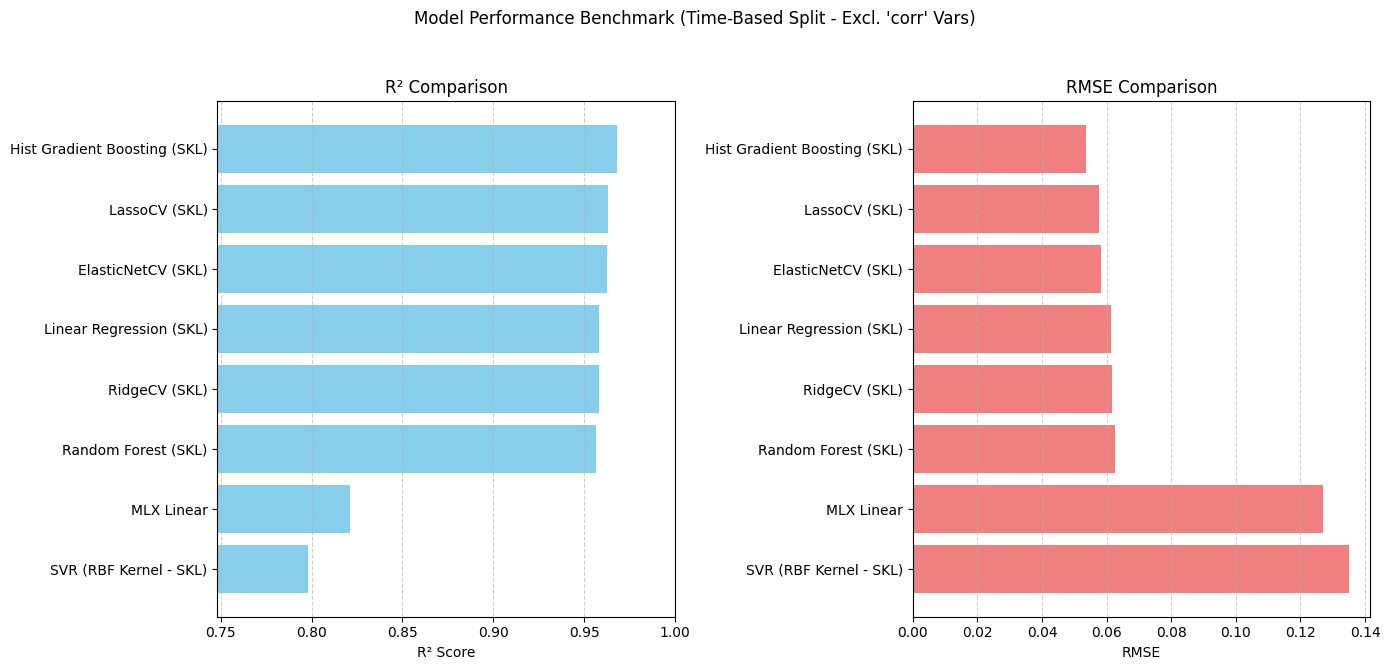


--- Analyzing Coefficients from Linear Models (Time-Based Split) ---

Processing Coefficients: RidgeCV (SKL)
--- Top 15 Predictors for RidgeCV (SKL) ---
           feature  coefficient
          v2x_rule      -0.3157
        v2x_neopat       0.2682
        v2x_civlib      -0.2018
         v2xcl_rol       0.1707
         v2x_jucon       0.1427
        v2xnp_pres      -0.1280
v2x_accountability       0.0993
       v2x_egaldem       0.0635
     v2x_polyarchy      -0.0603
  v2x_EDcomp_thick       0.0595
       v2xcl_acjst      -0.0567
        v2x_libdem      -0.0527
           v2x_mpi      -0.0502
         v2x_clphy       0.0493
    v2xeg_eqprotec      -0.0458

Processing Coefficients: LassoCV (SKL)
  LassoCV selected 176 non-zero features.
--- Top 15 (Non-Zero) Predictors for LassoCV (SKL) ---
                  feature  coefficient
                 v2x_rule      -0.3220
               v2x_neopat       0.2182
               v2xnp_pres      -0.0957
                v2x_jucon       0.0957
  

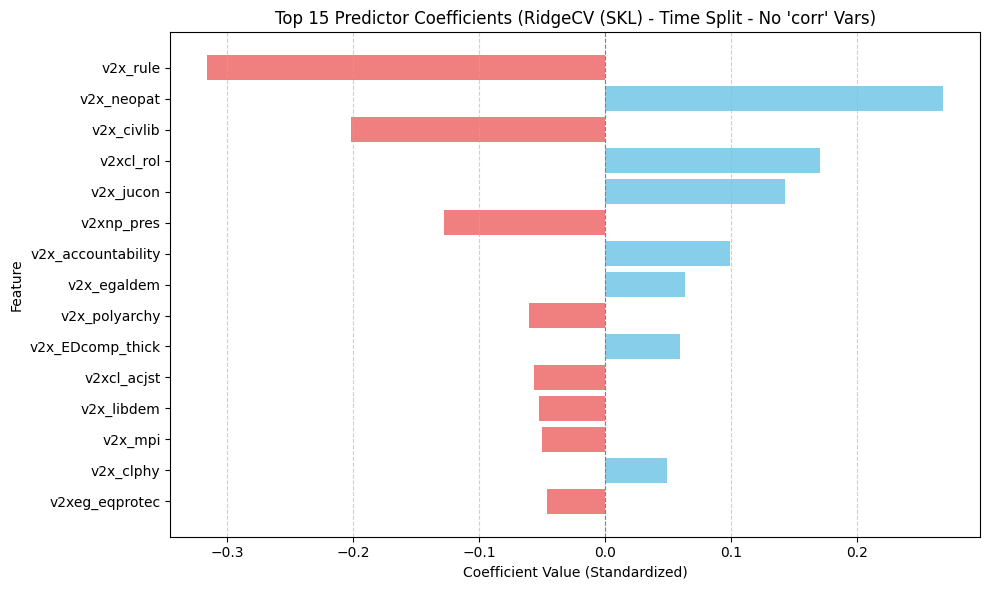


--- Visualizing Top Tree Feature Importances (Example: Random Forest - Time-Based Split) ---


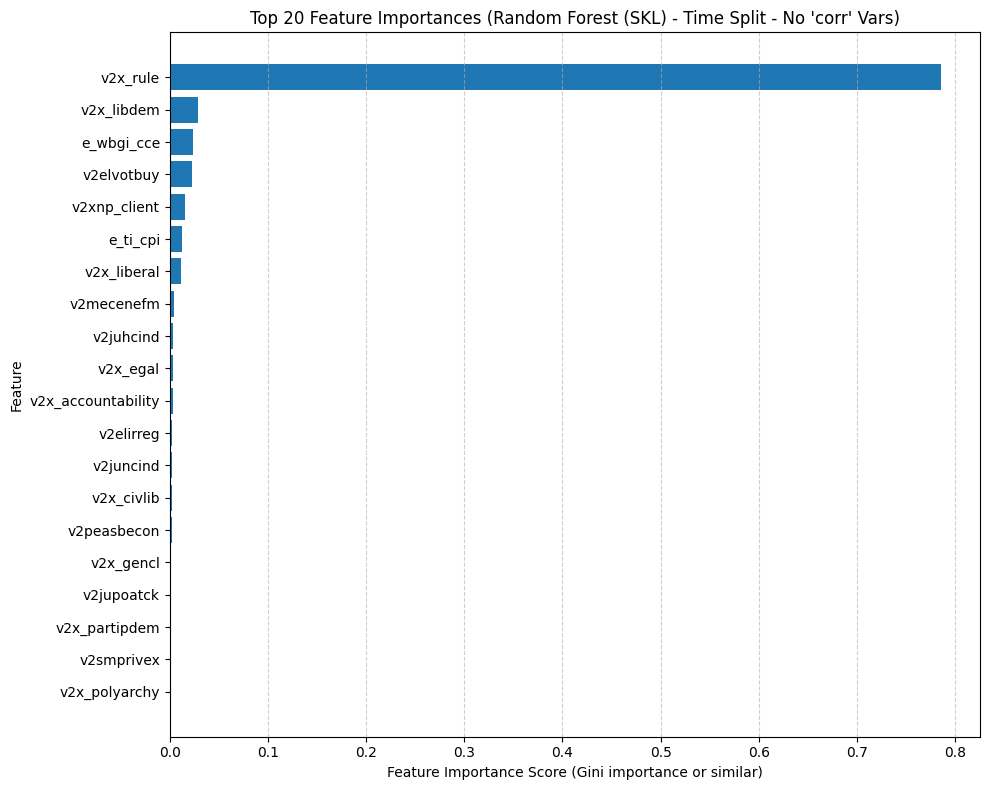


--- Script Finished ---


In [8]:
# 0. ── Imports ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import math # Needed for floor/ceil if using percentage split index precisely

# --- Add tqdm import ---
from tqdm.auto import tqdm # Auto-detects notebook or console environment
# ---

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Scikit-learn Imports
# from sklearn.model_selection import train_test_split # Correctly removed
from sklearn.preprocessing import StandardScaler
# Linear Models
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# Non-Linear Models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
# Metrics & Version
from sklearn.metrics import r2_score, mean_squared_error
import sklearn

# Optional: Scipy for QQ plot
from scipy import stats

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Check Scikit-learn version
print(f"Scikit-learn version: {sklearn.__version__}")


# 1. ── Data Loading and Initial Setup ───────────────────────────────────────
try:
    df = pd.read_csv("../temp/df_imputed.csv")
    print(f"Data shape: {df.shape}")
    print(f"Any missing values? {df.isna().sum().sum()} (should be 0)")
except FileNotFoundError:
    print("Error: df_imputed.csv not found. Creating dummy data.")
    n_samples=1000; n_features=50
    feature_names = [f'feature_{i}' for i in range(n_features)] + ['some_correlation_measure']
    extra_cols = ['country_name','country_text_id','country_id','year','v2x_corr','e_gdppc_imputed_rf','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps']
    all_cols=list(set(feature_names + extra_cols)); df=pd.DataFrame(np.random.rand(n_samples, len(all_cols)), columns=all_cols)
    df['v2x_corr']=(np.sin(df['feature_0']*np.pi)*0.5+df['feature_1']*-0.3+np.square(df['feature_2'])*0.2+np.random.randn(n_samples)*0.5)
    if 'e_gdppc_imputed_rf' in df.columns: df['e_gdppc_imputed_rf']=np.exp(df['feature_2']*3+10)
    for col in ['v2x_pubcorr','v2x_execorr','v2lgcrrpt','v2jucorrdc','v2exbribe','v2exembez','v2excrptps','v2exthftps','e_v2x_corr_4C','v2x_polyarchy_imputed_rf','v2x_delibdem_imputed','some_correlation_measure']:
         if col in df.columns: df[col]=df['feature_0']*(0.2+0.6*np.random.rand(n_samples))+np.random.rand(n_samples)*0.1
    df['country_name']=[f'Country_{i%10}' for i in range(n_samples)]; df['country_text_id']=[f'C{i%10}' for i in range(n_samples)]
    df['country_id']=[i%10 for i in range(n_samples)]; df['year']=[1950+i//20 for i in range(n_samples)]


# 2. ── Define Target & Predictors, Drop Problematic Columns ────────────────
target="v2x_corr"; base_drop_cols=["country_name","country_text_id","country_id","year",target] # Keep 'year' initially
base_drop_cols=[col for col in base_drop_cols if col in df.columns and col != 'year']; numeric_cols=df.select_dtypes(include=[np.number]).columns.tolist()
predictors=[c for c in numeric_cols if c not in base_drop_cols and c != target and c != 'year']
print(f"Identified {len(predictors)} potential numeric predictors initially (excluding year).")
manual_drop_cols=["e_v2x_corr_3C","e_v2x_corr_4C","e_v2x_corr_5C","v2x_delibdem_imputed","v2xel_frefair_imputed","v2xdl_delib_imputed","e_v2xdl_delib_4C_imputed","e_v2xdl_delib_5C_imputed","e_v2x_delibdem_3C_imputed","e_v2x_delibdem_4C_imputed","e_v2x_delibdem_5C_imputed","e_v2xel_frefair_3C_imputed","e_v2xel_frefair_4C_imputed","e_v2xel_frefair_5C_imputed","v2clpolcl_imputed_rf","v2peasjsoecon_imputed_rf","v2peapsgen_imputed_rf","v2peasjgen_imputed_rf","v2xpe_exlecon_imputed_rf","v2x_polyarchy_imputed_rf","v2x_libdem_imputed_rf","v2x_partipdem_imputed_rf","v2x_egaldem_imputed_rf","v2x_mpi_imputed_rf","v2x_liberal_imputed_rf","v2x_regime_imputed_rf","v2x_regime_amb_imputed_rf","v2x_EDcomp_thick_imputed_rf","e_v2x_egaldem_3C_imputed_rf","e_v2x_egaldem_4C_imputed_rf","e_v2x_egaldem_5C_imputed_rf","e_v2x_libdem_3C_imputed_rf","e_v2x_libdem_4C_imputed_rf","e_v2x_libdem_5C_imputed_rf","e_v2x_mpi_5C_imputed_rf","e_v2x_EDcomp_thick_5C_imputed_rf","e_v2x_liberal_4C_imputed_rf","e_v2x_liberal_5C_imputed_rf","e_v2x_polyarchy_5C_imputed_rf","v2x_pubcorr","v2x_execorr","v2lgcrrpt","v2jucorrdc","v2exbribe","v2exembez","v2excrptps","v2exthftps",]
corr_containing_cols=[p for p in predictors if "corr" in p.lower()]
print(f"Found {len(corr_containing_cols)} predictors containing 'corr'.")
cols_to_drop=list(set(manual_drop_cols+corr_containing_cols))
cols_to_drop_existing=[col for col in cols_to_drop if col in predictors]
predictors=[p for p in predictors if p not in cols_to_drop_existing]
print(f"Dropped {len(cols_to_drop_existing)} columns (manual list + 'corr' containing).")


# 3. ── Log Transform GDP ────────────────────────────────────────────────────
gdp_var="e_gdppc_imputed_rf"
if gdp_var in predictors and gdp_var in df.columns:
    min_val=df[gdp_var].min()
    if min_val<=0:offset=-min_val+1e-6;print(f"Warning: '{gdp_var}' non-positive. Adding {offset:.2e} before log.");df["log_gdppc"]=np.log(df[gdp_var]+offset)
    else: df["log_gdppc"]=np.log(df[gdp_var])
    predictors=[p for p in predictors if p!=gdp_var]+["log_gdppc"];print(f"Replaced {gdp_var} with log_gdppc.")
elif gdp_var in cols_to_drop_existing: print(f"'{gdp_var}' was previously dropped.")
else: print(f"'{gdp_var}' not found or already processed.")
predictors=[p for p in predictors if p in df.columns]
if not predictors: raise ValueError("No valid predictor columns remain.")
print(f"Using {len(predictors)} final predictors for the models.")


# 4. ── Prepare Data: Select final columns & Sort by Year ───────────────────
time_col = 'year'
if time_col not in df.columns: raise ValueError(f"Time column '{time_col}' not found.")
print(f"\n--- Sorting Data by '{time_col}' for Time-Based Split ---")
df_cleaned = df[[time_col] + predictors + [target]].dropna().sort_values(by=time_col).reset_index(drop=True)
print(f"Shape after dropping NAs and sorting: {df_cleaned.shape}")
X_sorted = df_cleaned[predictors]
y_sorted = df_cleaned[target]


# 5. ── Time-Based Train/Test Split ──────────────────────────────────────────
train_ratio = 0.80
split_index = math.floor(len(df_cleaned) * train_ratio)
if split_index == 0 or split_index == len(df_cleaned): raise ValueError(f"Train ratio {train_ratio} results in empty train or test set.")
X_train_pd = X_sorted.iloc[:split_index]; X_test_pd = X_sorted.iloc[split_index:]
y_train_pd = y_sorted.iloc[:split_index]; y_test_pd = y_sorted.iloc[split_index:]
train_years = df_cleaned.iloc[:split_index][time_col]; test_years = df_cleaned.iloc[split_index:][time_col]
print("\n--- Performing Time-Based Split ---")
print(f"Splitting at index {split_index} ({(train_ratio*100):.0f}% train / {((1-train_ratio)*100):.0f}% test)")
print(f"Training data time range: {train_years.min()} - {train_years.max()}")
print(f"Test data time range:     {test_years.min()} - {test_years.max()}")
print(f"Train set shape: {X_train_pd.shape}, Test set shape: {X_test_pd.shape}")
y_train_np = y_train_pd.values; y_test_np = y_test_pd.values


# 6. ── Standardize Features (Fit on Train, Transform Train & Test) ──────────
print("\n--- Standardizing Features (Fit on Train, Transform Train & Test) ---")
scaler = StandardScaler(); X_train_np = scaler.fit_transform(X_train_pd); X_test_np = scaler.transform(X_test_pd)
print("Standardization complete using training set parameters.")


# 7. ── Prepare Data for MLX (Convert NumPy to MLX) ─────────────────────────
X_train_mx = mx.array(X_train_np, dtype=mx.float32); X_test_mx = mx.array(X_test_np, dtype=mx.float32)
y_train_mx = mx.array(y_train_np, dtype=mx.float32).reshape(-1, 1)


# 8. ── Define MLX Linear Regression Model & Training Function (Corrected) ──
class MlxLinearRegression(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        if num_features <= 0: raise ValueError(f"Num features must be > 0, got {num_features}")
        self.linear = nn.Linear(num_features, 1)
    def __call__(self, x: mx.array) -> mx.array:
        return self.linear(x)

def train_mlx_model(X_train,y_train,num_features,epochs=500,batch_size=128,lr=0.01):
    print(f"  Training MLX Linear (Epochs: {epochs}, Batch: {batch_size}, LR: {lr})...");
    model=MlxLinearRegression(num_features)
    mx.eval(model.parameters()) # Initialize before defining loss/grad
    def mse_loss(model, x, y): # Define local loss function on a new line
        return nn.losses.mse_loss(model(x), y, reduction='mean')
    loss_and_grad_fn=nn.value_and_grad(model,mse_loss);
    optimizer=optim.Adam(learning_rate=lr);
    start_time=time.time();
    model.train()
    for epoch in tqdm(range(epochs), desc="    MLX Epochs", leave=False, ncols=100, mininterval=0.5):
        permutation=mx.array(np.random.permutation(X_train.shape[0]));
        for i in range(0,X_train.shape[0],batch_size):
            batch_indices=permutation[i:i+batch_size];
            X_batch,y_batch=X_train[batch_indices],y_train[batch_indices];
            loss,grads=loss_and_grad_fn(model,X_batch,y_batch);
            optimizer.update(model,grads);
            mx.eval(model.parameters(),optimizer.state) # Ensure updates happen
    end_time=time.time();
    training_time=end_time-start_time;
    print(f"  MLX Training finished in {training_time:.2f} seconds.");
    model.eval();
    return model,training_time


# 9. ── Define Models to Benchmark ───────────────────────────────────────────
models_to_benchmark={"MLX Linear":None,"Linear Regression (SKL)":SkLinearRegression(),"RidgeCV (SKL)":RidgeCV(alphas=np.logspace(-6,6,13),cv=5),"LassoCV (SKL)":LassoCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"ElasticNetCV (SKL)":ElasticNetCV(cv=5,random_state=42,max_iter=5000,tol=0.001),"Random Forest (SKL)":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1),"Hist Gradient Boosting (SKL)":HistGradientBoostingRegressor(random_state=42),"SVR (RBF Kernel - SKL)":SVR()}
num_features=X_train_np.shape[1]
if num_features<=0: raise ValueError("No features left after dropping.")


# 10. ── Run Benchmark Loop & Store Trained Models (with tqdm) ──────────────
print("\n--- Starting Model Benchmarking (Time-Based Split) ---")
benchmark_results = []
trained_models = {}

for name, model_instance in tqdm(models_to_benchmark.items(), desc="Benchmarking Models", ncols=100):
    preds_np=None; training_time=None; current_trained_model=None
    try:
        if name=="MLX Linear": current_trained_model,training_time=train_mlx_model(X_train_mx,y_train_mx,num_features,epochs=500); print(f"  Predicting with {name}..."); start_pred_time=time.time(); preds_mx=current_trained_model(X_test_mx); mx.eval(preds_mx); preds_np=np.array(preds_mx).flatten(); print(f"  {name} prediction finished in {time.time()-start_pred_time:.2f} seconds.")
        else: current_trained_model=model_instance; print(f"  Training {name}..."); start_time=time.time(); current_trained_model.fit(X_train_np,y_train_np); end_time=time.time(); training_time=end_time-start_time; print(f"  {name} Training finished in {training_time:.2f} seconds."); print(f"  Predicting with {name}..."); start_pred_time=time.time(); preds_np=current_trained_model.predict(X_test_np); print(f"  {name} prediction finished in {time.time()-start_pred_time:.2f} seconds.")
        print(f"  Evaluating {name}..."); r2=r2_score(y_test_np,preds_np); mse=mean_squared_error(y_test_np,preds_np); rmse=np.sqrt(mse); print(f"  {name} Results -> Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")
        benchmark_results.append({"Model":name,"Test R²":r2,"Test RMSE":rmse,"Training Time (s)":training_time})
        if name in ["RidgeCV (SKL)","LassoCV (SKL)","MLX Linear","Random Forest (SKL)","Hist Gradient Boosting (SKL)"]: trained_models[name]=current_trained_model
    except Exception as e: print(f"\n  ERROR processing {name}: {e}"); import traceback; traceback.print_exc(); benchmark_results.append({"Model":name,"Test R²":np.nan,"Test RMSE":np.nan,"Training Time (s)":training_time if training_time is not None else np.nan})


# 11. ── Display Benchmark Results ───────────────────────────────────────────
print("\n--- Benchmark Results (Time-Based Split) ---")
results_df=pd.DataFrame(benchmark_results)
if not results_df.empty: results_df=results_df.sort_values(by="Test R²",ascending=False).reset_index(drop=True); print(results_df.to_string(index=False,float_format="%.4f"))
else: print("No benchmark results were generated.")


# 12. ── Plot Benchmark Results ───────────────────────────────────────────────
if not results_df.empty and not results_df['Test R²'].isnull().all():
    fig,axes=plt.subplots(1,2,figsize=(14,7)); fig.suptitle("Model Performance Benchmark (Time-Based Split - Excl. 'corr' Vars)")
    plot_df_r2=results_df.dropna(subset=['Test R²']).sort_values("Test R²"); plot_df_rmse=results_df.dropna(subset=['Test RMSE']).sort_values("Test RMSE",ascending=False)
    if not plot_df_r2.empty: axes[0].barh(plot_df_r2["Model"],plot_df_r2["Test R²"],color='skyblue'); axes[0].set_xlabel("R² Score"); axes[0].set_title("R² Comparison"); min_r2=plot_df_r2["Test R²"].min(); axes[0].set_xlim(left=max(-0.1,min_r2-0.05),right=1.0); axes[0].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[0].set_title("R² Comparison (No Data)")
    if not plot_df_rmse.empty: axes[1].barh(plot_df_rmse["Model"],plot_df_rmse["Test RMSE"],color='lightcoral'); axes[1].set_xlabel("RMSE"); axes[1].set_title("RMSE Comparison"); axes[1].grid(axis='x',linestyle='--',alpha=0.6)
    else: axes[1].set_title("RMSE Comparison (No Data)")
    plt.tight_layout(rect=[0,0.03,1,0.95]); plt.show()
elif not results_df.empty: print("\nPlotting skipped: All models failed or produced NaN results.")
else: print("\nPlotting skipped: No results available.")


# 13. ── Extract and Analyze Linear Model Coefficients ──────────────────────
print("\n--- Analyzing Coefficients from Linear Models (Time-Based Split) ---")

N_TOP_FEATURES_LINEAR = 15
linear_coef_dfs = {}
model_name = "RidgeCV (SKL)"

if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    ridge_model = trained_models[model_name]
    ridge_coefs = pd.DataFrame({
        'feature': predictors,
        'coefficient': ridge_model.coef_
    })
    ridge_coefs['abs_coef'] = ridge_coefs['coefficient'].abs()
    ridge_coefs = (
        ridge_coefs
        .sort_values('abs_coef', ascending=False)
        .reset_index(drop=True)
    )
    linear_coef_dfs[model_name] = ridge_coefs

    print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---")
    print(
        ridge_coefs[['feature', 'coefficient']]
        .head(N_TOP_FEATURES_LINEAR)
        .to_string(index=False, float_format="%.4f")
    )
else:
    print(f"\n{model_name} not found for coefficient analysis.")


# --- Corrected LassoCV Indentation ---
model_name="LassoCV (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}");
    lasso_model=trained_models[model_name];
    lasso_coefs=pd.DataFrame({'feature':predictors,'coefficient':lasso_model.coef_});
    lasso_coefs['abs_coef']=lasso_coefs['coefficient'].abs();
    lasso_coefs_nonzero=lasso_coefs[lasso_coefs['coefficient']!=0].copy();
    lasso_coefs_nonzero=lasso_coefs_nonzero.sort_values('abs_coef',ascending=False).reset_index(drop=True);
    linear_coef_dfs[model_name]=lasso_coefs_nonzero;
    print(f"  LassoCV selected {len(lasso_coefs_nonzero)} non-zero features.");
    print(f"--- Top {N_TOP_FEATURES_LINEAR} (Non-Zero) Predictors for {model_name} ---");
    if not lasso_coefs_nonzero.empty: # This line needs to be at the same level as the print above it
        print(lasso_coefs_nonzero[['feature','coefficient']].head(N_TOP_FEATURES_LINEAR).to_string(index=False,float_format="%.4f"))
    else: # This line needs to be at the same level as the if above it
        print("  LassoCV selected 0 features.")
else:
    print(f"\n{model_name} not found for coefficient analysis.")
# --- End Correction ---

# 13b. ── Extract and Analyze MLX Linear Model Coefficients ────────────
model_name = "MLX Linear"

if model_name in trained_models:
    print(f"\nProcessing Coefficients: {model_name}")
    mlx_model = trained_models[model_name]

    # make sure the weights tensor is materialized
    mx.eval(mlx_model.linear.weight)

    # pull out a flat numpy array of coefficients
    mlx_weights = np.array(mlx_model.linear.weight.squeeze())

    # sanity check length
    if len(predictors) == len(mlx_weights):
        mlx_coefs = pd.DataFrame({
            'feature': predictors,
            'coefficient': mlx_weights
        })
        mlx_coefs['abs_coef'] = mlx_coefs['coefficient'].abs()
        mlx_coefs = (
            mlx_coefs
            .sort_values('abs_coef', ascending=False)
            .reset_index(drop=True)
        )
        linear_coef_dfs[model_name] = mlx_coefs

        print(f"--- Top {N_TOP_FEATURES_LINEAR} Predictors for {model_name} ---")
        print(
            mlx_coefs[['feature', 'coefficient']]
            .head(N_TOP_FEATURES_LINEAR)
            .to_string(index=False, float_format="%.4f")
        )
    else:
        msg = (
            f"  ERROR: Mismatch predictor count "
            f"({len(predictors)}) vs MLX weights ({len(mlx_weights)})."
        )
        print(msg)
else:
    print(f"\n{model_name} not found for coefficient analysis.")


# 14. ── Extract and Analyze Tree Model Feature Importances ─────────────
print("\n--- Analyzing Feature Importances from Tree-Based Models (Time-Based Split) ---")

N_TOP_FEATURES_TREE = 20
tree_importance_dfs = {}

# Random Forest
model_name = "Random Forest (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Feature Importances: {model_name}")
    rf_model = trained_models[model_name]

    rf_importances = pd.DataFrame({
        'feature':      predictors,
        'importance':   rf_model.feature_importances_
    })
    rf_importances = (
        rf_importances
        .sort_values('importance', ascending=False)
        .reset_index(drop=True)
    )
    tree_importance_dfs[model_name] = rf_importances

    print(f"--- Top {N_TOP_FEATURES_TREE} Features for {model_name} ---")
    print(
        rf_importances
        .head(N_TOP_FEATURES_TREE)
        .to_string(index=False, float_format="%.4f")
    )
else:
    print(f"\n{model_name} not found for importance analysis.")

# HistGradientBoosting (skip detailed example)
model_name = "Hist Gradient Boosting (SKL)"
if model_name in trained_models:
    print(f"\nProcessing Feature Importances: {model_name}")
    print(
        f"  Feature importance extraction for {model_name} "
        "(requires permutation_importance; skipped in this example)."
    )
else:
    print(f"\n{model_name} not found for importance analysis.")


# 15. ── Visualize Coefficients & Importances ────────────────────────────
# ---- 15a: Linear Coefficients ----
print(
    "\n--- Visualizing Top Linear Predictor Coefficients "
    "(Example: RidgeCV - Time-Based Split) ---"
)

model_to_plot_lin = "RidgeCV (SKL)"
if (model_to_plot_lin in linear_coef_dfs
        and not linear_coef_dfs[model_to_plot_lin].empty):

    plot_data = (
        linear_coef_dfs[model_to_plot_lin]
        .head(N_TOP_FEATURES_LINEAR)
        .sort_values('abs_coef')
    )

    plt.figure(figsize=(10, max(6, N_TOP_FEATURES_LINEAR / 2.5)))
    colors = [
        'lightcoral' if c < 0 else 'skyblue'
        for c in plot_data['coefficient']
    ]
    plt.barh(
        plot_data['feature'],
        plot_data['coefficient'],
        color=colors
    )
    plt.xlabel("Coefficient Value (Standardized)")
    plt.ylabel("Feature")
    plt.title(
        f"Top {N_TOP_FEATURES_LINEAR} Predictor Coefficients "
        f"({model_to_plot_lin} - Time Split - No 'corr' Vars)"
    )
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping linear coefficient plot: No data found for {model_to_plot_lin}.")


# ---- 15b: Tree Importances ----
print(
    "\n--- Visualizing Top Tree Feature Importances "
    "(Example: Random Forest - Time-Based Split) ---"
)

model_to_plot_tree = "Random Forest (SKL)"
if (model_to_plot_tree in tree_importance_dfs
        and not tree_importance_dfs[model_to_plot_tree].empty):

    plot_data = (
        tree_importance_dfs[model_to_plot_tree]
        .head(N_TOP_FEATURES_TREE)
        .sort_values('importance')
    )

    plt.figure(figsize=(10, max(6, N_TOP_FEATURES_TREE / 2.5)))
    plt.barh(plot_data['feature'], plot_data['importance'])
    plt.xlabel("Feature Importance Score (Gini importance or similar)")
    plt.ylabel("Feature")
    plt.title(
        f"Top {N_TOP_FEATURES_TREE} Feature Importances "
        f"({model_to_plot_tree} - Time Split - No 'corr' Vars)"
    )
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping tree importance plot: No data found for {model_to_plot_tree}.")


print("\n--- Script Finished ---")
